<a href="https://colab.research.google.com/github/XuRui314/MathematicalModeling/blob/main/2020_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>这是谢哥的代码，原仓库地址在：https://github.com/Xyhi/Mathematical-Modeling

In [56]:
# preparation
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
os.chdir("/content/drive/MyDrive/dataset/MathModel/2020C")
!ls

 data1_1.xlsx   data2_3.xlsx   第一问所有特征.csv
 data1_2.xlsx   data2.xlsx     附件1：123家有信贷记录企业的相关数据.xlsx
 data1_3.xlsx   data3.xlsx
 data2_2.xlsx  'SimHei .ttf'


In [58]:
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
import matplotlib.pyplot as plt
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
!gdown --id 1fsKERl26TNTFIY25PhReoCujxwJvfyHn

--2023-01-11 11:59:55--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  58.9MB/s    in 0.2s    

2023-01-11 11:59:55 (58.9 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fsKERl26TNTFIY25PhReoCujxwJvfyHn
To: /content/drive/MyDrive/dataset/MathModel/2020C/SimHei .ttf
100% 10.1M/10.1M [00:00<00:00, 34.1MB/s]


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')  

fontManager.addfont('SimHei .ttf')
mpl.rc('font', family='SimHei')

In [60]:
pip install geatpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 问题一

首先明确银行在贷款额度$A$(可假设为5千万)确定的情况下,确定其收益的目标函数$W=\sum_{i=1}^{n}[ a_i\cdot r\cdot(1-m_i)-a_i\cdot m_i\cdot(1-l_k)  ]$

$a_i$:为每个企业贷款的金额 $r$:银行贷款率 $m_i$:每个企业违规率 $l_k$:信誉等级为$k$的企业客户流失率

故首要目的就是根据企业的用户评级,企业的发票信息,构建出对其违约率的预测模型,即可以确定$m_i$

再根据附件3中的数据,根据贷款年利率和不同的信誉等级,拟合出$l_k$与贷款年利率r以及信誉等级的函数$f(r,l)$


## 1.1 构建企业违约率模型

首先确定企业的各项指标
* 企业信誉等级
* 企业违约情况
* 企业营业额
* 企业异常发票率
* 企业盈余增长率

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math
from numpy import array
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np
import geatpy as ea
import time
import warnings
warnings.filterwarnings('ignore') 

In [62]:
data1_1 = pd.read_excel('data1_1.xlsx')
data1_2 = pd.read_excel('data1_2.xlsx')
data1_3 = pd.read_excel('data1_3.xlsx')
# 均无缺失值
print(data1_1.info())
print(data1_2.info())
print(data1_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   企业代号    123 non-null    object
 1   企业名称    123 non-null    object
 2   信誉评级    123 non-null    object
 3   是否违约    123 non-null    object
dtypes: object(4)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210947 entries, 0 to 210946
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   企业代号    210947 non-null  object        
 1   发票号码    210947 non-null  int64         
 2   开票日期    210947 non-null  datetime64[ns]
 3   销方单位代号  210947 non-null  object        
 4   金额      210947 non-null  float64       
 5   税额      210947 non-null  float64       
 6   价税合计    210947 non-null  float64       
 7   发票状态    210947 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 12

如果出现缺失值可以看看缺失值数目多不多，其分布是怎么样的，kaggle有很多案例可以参考。

In [63]:
data3 = pd.read_excel('data3.xlsx',skiprows=2, header=None)
data3.columns = ['贷款年利率','A','B','C']
print(data3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   贷款年利率   29 non-null     float64
 1   A       29 non-null     float64
 2   B       29 non-null     float64
 3   C       29 non-null     float64
dtypes: float64(4)
memory usage: 1.0 KB
None


对信誉等级进行打分,{A:10 B:7 C:4 D:1}

对违约情况进行打分, {'是':1 '否':10}

In [64]:
# 首先观察A,B,C,D的违约情况
dict1 = {'否': 0, '是': 1}
data1_1['是否违约'] = data1_1['是否违约'].apply(lambda x: dict1[x])

In [65]:
# 可以看到D类型的都违约了,A类型几乎没有违约
data1_1.groupby('信誉评级')['是否违约'].mean()

信誉评级
A    0.000000
B    0.026316
C    0.058824
D    1.000000
Name: 是否违约, dtype: float64

In [66]:
data = pd.DataFrame()

In [67]:
dict2 = {'A':10, 'B':7, 'C':4, 'D':0}
data['违约得分'] = data1_1['是否违约'].apply(lambda x: 5 if x == 0 else 1)
data['信誉评级得分'] = data1_1['信誉评级'].apply(lambda x: dict2[x])

* 企业营业额=销项金额-进项金额-增值税额  增值税额=销项税额-进项税额
* 企业违规率=$0.2\cdot q_1 + 0.8\cdot q_2$: $q_1$为作废发票占比,$q_2$为销项负数占比,企业守信程度=1-违规率
* 企业营业额增长速率=每月营业额增长率均值: 通过观察数据发现销项和进项的月份差异很大,会出现某个月没有销项的情况,此时用每年的总营业额除以月份作为每年的月平均增长率

In [68]:
def cal_trustworthiness(df1,df2):
    df1['发票状态'] = df1['发票状态'].apply(lambda x: 0 if x=='有效发票' else 1)
    df2['发票状态'] = df2['发票状态'].apply(lambda x: 0 if x=='有效发票' else 1)
    minus_num = df2.groupby('企业代号',sort=False).agg({'金额': lambda x: np.sum((x < 0))})
    # 获取企业违规率
    col1 = df1.groupby('企业代号',sort=False)['发票状态']
    col2 = df2.groupby('企业代号',sort=False)['发票状态']
    col3 = minus_num['金额']
    col = 0.2*((col1.sum()+col2.sum())/(col1.count()+col2.count())) + 0.8*(col3/col2.count())
    # 删除作废发票
    df1.drop(index=df1[df1['发票状态']==1].index.tolist(),inplace=True) # inplace = True 不创建新的对象，直接对原始对象进行修改
    df2.drop(index=df2[df2['发票状态']==1].index.tolist(),inplace=True)
    return col

col = cal_trustworthiness(data1_2, data1_3)
data['企业守信度'] = 1- col.values
# 删除作废发票
data

,违约得分,信誉评级得分,企业守信度
0,5,10,0.970208
1,5,10,0.969476
2,5,4,0.846377
3,5,4,0.980495
4,5,7,0.983781
...,...,...,...
118,1,0,0.997619
119,1,0,0.935385
120,1,0,0.980508
121,1,0,0.925281


In [69]:
# 获取cal_turnover
def cal_turnover(df1,df2,df3):
    col2_1 = df1.groupby('企业代号',sort=False)['金额']
    col2_2 = df1.groupby('企业代号',sort=False)['税额']
    col3_1 = df2.groupby('企业代号',sort=False)['金额']
    col3_2 = df2.groupby('企业代号',sort=False)['税额']

    col = col3_1.sum() - col2_1.sum() - (col3_2.sum() - col2_2.sum())
    df3['销项额度'] = col3_1.sum().values
    df3['销项税额'] = col3_2.sum().values
    df3['进项额度'] = col2_1.sum().values
    df3['进项税额'] = col2_2.sum().values
    return col

col = cal_turnover(data1_2,data1_3,data1_1)
data['企业营业额'] = col.values
data.head()

,违约得分,信誉评级得分,企业守信度,企业营业额
0,5,10,0.970208,-1.418417e+09
1,5,10,0.969476,4.063511e+08
2,5,4,0.846377,4.294111e+08
3,5,4,0.980495,1.348229e+09
4,5,7,0.983781,3.735886e+06


In [70]:
def cal_growth_rate(df1,df2,list1):
    # 获取企业盈余增长率
    df1['开票年月'] = df1['开票日期'].dt.year.astype(str) + '-' + df1['开票日期'].dt.month.astype(str)
    # data1_2.drop('开票日期',axis=1,inplace=True)
    df2['开票年月'] = df2['开票日期'].dt.year.astype(str) + '-' + df2['开票日期'].dt.month.astype(str)
    # data1_3.drop('开票日期',axis=1,inplace=True)
    df1['开票年'] = df1['开票日期'].dt.year
    df2['开票年'] = df2['开票日期'].dt.year

    col2_3 = df1.groupby(['企业代号','开票年'],sort=False).agg({'金额': 'sum', '税额': 'sum'})
    col3_3 = df2.groupby(['企业代号','开票年'],sort=False).agg({'金额': 'sum', '税额': 'sum'})
    col2_3['id'] = col2_3.index.to_numpy()
    col3_3['id'] = col3_3.index.to_numpy()
    

    col_final = pd.merge(col2_3,col3_3,on='id',how='outer')
    col_final = col_final.fillna(0)
    l = len(list1)

    list2 = ['2016','2017','2018','2019','2020']
    num1 = np.zeros((l,5))
    num2 = np.zeros((l,5))
    for name in df1.groupby(['企业代号','开票年月'],sort=False):
        idx = list1.index(name[0][0])
        col = list2.index(name[0][1][:4])
        num1[idx][col] = num1[idx][col] + 1

    for name in df2.groupby(['企业代号','开票年月'],sort=False):
        idx = list1.index(name[0][0])
        col = list2.index(name[0][1][:4])
        num2[idx][col] = num2[idx][col] + 1
    
    num = [max(num1[i][j],num2[i][j]) for i in range(l) for j in range(5)]

    earn = col_final.iloc[:,3]-col_final.iloc[:,0]-(col_final.iloc[:,4]-col_final.iloc[:,1])
    bg0_num = [i for i in num if i > 0]
    rate_list = np.zeros((l,5)).astype(float)
    idx = -1
    for i in range(l):
        flag = True
        for j in range(5):
            if num[i*5 + j] != 0:
                idx = idx + 1 
                if flag:
                    flag = False
                    rate_list[i][j] = 0
                else:
                    mean_pre = earn[idx-1]/bg0_num[idx-1]
                    mean_cor = earn[idx]/bg0_num[idx]
                    rate_list[i][j] = (mean_cor - mean_pre)/mean_pre
            else:
                rate_list[i][j] = 0
    mean_list = rate_list.mean(axis=1)
    return mean_list


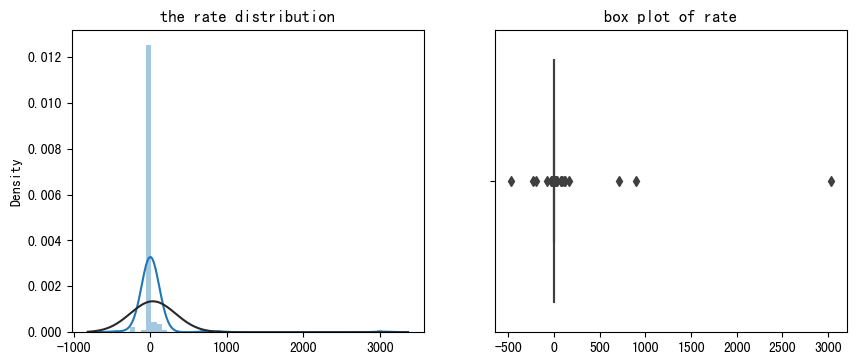

,违约得分,信誉评级得分,企业守信度,企业营业额,企业盈余增长率
0,5,10,0.970208,-1.418417e+09,-0.120078
1,5,10,0.969476,4.063511e+08,0.265757
2,5,4,0.846377,4.294111e+08,-0.155133
3,5,4,0.980495,1.348229e+09,-0.506116
4,5,7,0.983781,3.735886e+06,-15.515429
...,...,...,...,...,...
118,1,0,0.997619,-1.551409e+05,88.528348
119,1,0,0.935385,1.681682e+05,-0.331950
120,1,0,0.980508,-8.072160e+05,-0.133322
121,1,0,0.925281,9.505080e+03,0.817297


In [71]:
append_index = np.arange(1, 124)

list1 = [0]*123
for i in range(123):
    list1[i] = 'E' + str(append_index[i])
mean_list = cal_growth_rate(data1_2,data1_3,list1)
data['企业盈余增长率'] = mean_list

# 考虑到企业基数问题
plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
plt.title('the rate distribution')
sns.distplot(mean_list, fit=norm)

plt.subplot(1,2,2)
sns.boxplot(mean_list)
plt.title('box plot of rate')
plt.show()
data

## 1.2 构建企业信誉评价体系

用熵权法确定权重,TOPSIS进行得分计算

In [72]:
def TOPSIS(data, w):
    # 数据标准化
    label_need = data.keys()
    data1 = data[label_need].values
    [m, n] = data1.shape
    data2 = data1.copy().astype('float')
    for j in range(0, n):
        data2[:, j] = data1[:, j] / np.sqrt(sum(np.square(data1[:, j])))

    # 计算加权重后的数据
    R = data2 * w
    
    # 计算最大最小值距离
    r_max = np.max(R, axis=0)  # 每个指标的最大值
    r_min = np.min(R, axis=0)  # 每个指标的最小值
    d_z = np.sqrt(np.sum(np.square((R - np.tile(r_max, (m, 1)))), axis=1))  # d+向量
    d_f = np.sqrt(np.sum(np.square((R - np.tile(r_min, (m, 1)))), axis=1))  # d-向量
    
    # 计算得分
    s = d_f / (d_z + d_f)
    return s

def cal_weight(x):
    # 标准化
    x = x.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))

    # k值
    rows = x.index.size  # 行值
    cols = x.columns.size  # 列值
    k = 1.0 / math.log(rows)

    # 矩阵计算 信息熵
    x = array(x)
    inf = [[None] * cols for i in range(rows)]
    inf = array(inf)
    for i in range(0, rows):
        for j in range(0, cols):
            if x[i][j] == 0:
                infij = 0
            else:
                p = x[i][j] / x.sum(axis=0)[j]
                infij = math.log(p) * p * (-k)
            inf[i][j] = infij
    inf = pd.DataFrame(inf)
    E = inf

    # 计算冗余度
    d = 1 - E.sum(axis=0)
    # 计算各指标的权重
    w = [[None] * 1 for i in range(cols)]
    for j in range(0, cols):
        wj = d[j] / sum(d)
        w[j] = wj
        # 计算各样本的综合得分,用最原始的数据

    w = pd.DataFrame(w)
    return w

可以观察到得分情况和信誉等级基本吻合,拟合较好

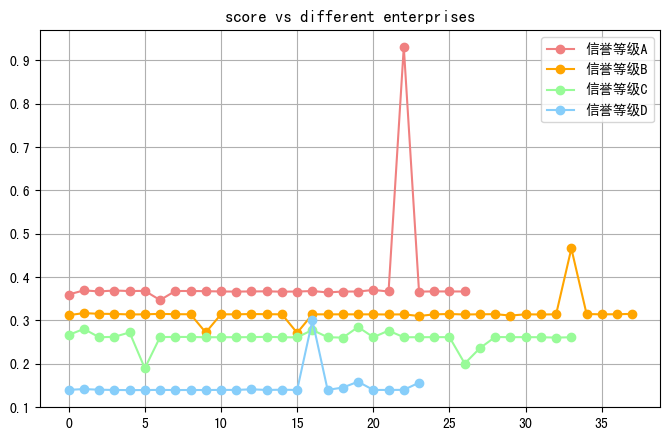

In [73]:
w = cal_weight(data)[0].tolist()
s = TOPSIS(data,w)

# 绘制出不同等级的得分情况
plt.figure(figsize=(8,5),dpi=100)
list_s = [10,7,4,0]
cset = ['lightcoral','orange','palegreen','lightskyblue']
labels = ['信誉等级A','信誉等级B','信誉等级C','信誉等级D']
for i in range(4):
    idx = data[data['信誉评级得分']==list_s[i]].index.tolist()
    plt.plot(range(len(idx)),s[idx],'-o',c=cset[i],label=labels[i])
plt.title('score vs different enterprises',style='italic')
plt.legend()
plt.grid()
plt.show()


可以大致得到违约率$m_i$同信誉得分成反比,故需要找到合适的拟合方式来确定违约率与信誉得分之间的关系,通过之前大致判断信誉等级D的企业均违约,绘制出大致的曲线

[-7.32711897e+02 -8.47671286e+02 -1.78245138e+02 -7.47977186e+02
  2.04081649e-02]


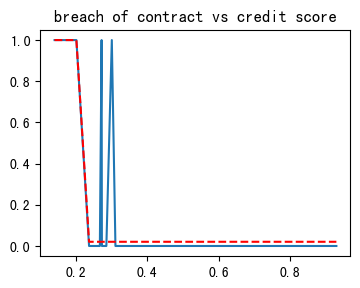

In [74]:
y_label = data1_1['是否违约'].values
idx = np.argsort(s)
s_tran = np.reshape(s, (-1,1))
plt.figure(figsize=(4,3),dpi=100)
plt.plot(np.sort(s), y_label[idx])
plt.title('breach of contract vs credit score', style='italic')

def func(x, a, b, c, d, e):
    return a *(1 / (np.exp(-b * x+c) + d)) + e
 
popt, pcov = curve_fit(func, np.sort(s), y_label[idx])
#popt数组中，三个值分别是待求参数a,b,c,d
y2 = np.array([func(i, popt[0],popt[1],popt[2], popt[3], popt[4]) for i in s])
plt.plot(np.sort(s), y2[idx], 'r--')
print(popt)
plt.show()

其实直接这么拿函数拟合的话，感觉还是有点太简单了，但是毕竟是数模比赛，言之有理自圆其说就可以了。

In [75]:
data['综合评分'] = s
data

,违约得分,信誉评级得分,企业守信度,企业营业额,企业盈余增长率,综合评分
0,5,10,0.970208,-1.418417e+09,-0.120078,0.359788
1,5,10,0.969476,4.063511e+08,0.265757,0.369363
2,5,4,0.846377,4.294111e+08,-0.155133,0.266435
3,5,4,0.980495,1.348229e+09,-0.506116,0.280389
4,5,7,0.983781,3.735886e+06,-15.515429,0.312155
...,...,...,...,...,...,...
118,1,0,0.997619,-1.551409e+05,88.528348,0.158587
119,1,0,0.935385,1.681682e+05,-0.331950,0.139536
120,1,0,0.980508,-8.072160e+05,-0.133322,0.139575
121,1,0,0.925281,9.505080e+03,0.817297,0.139769


很明显看出来突出偏大的三个点都是由于企业增长率这一项很大造成的，而B级别偏低的两个点是由于违约造成。

In [76]:
data.groupby('信誉评级得分').get_group(4)

,违约得分,信誉评级得分,企业守信度,企业营业额,企业盈余增长率,综合评分
2,5,4,0.846377,4.294111e+08,-0.155133,0.266435
3,5,4,0.980495,1.348229e+09,-0.506116,0.280389
10,5,4,0.989823,1.210509e+07,-1.663137,0.261135
13,5,4,0.974534,7.881510e+07,0.162532,0.262129
24,5,4,0.965859,2.421341e+07,78.923365,0.272297
28,1,4,0.996952,4.323195e+07,-76.668083,0.189549
38,5,4,0.970463,2.509766e+07,0.312019,0.261535
39,5,4,0.953861,2.890006e+07,2.968096,0.261923
40,5,4,0.969156,2.698293e+07,2.172104,0.261800
43,5,4,0.969381,2.570663e+06,-0.586331,0.261165


第一种优化的手段就是对增长率进行限制，套一个函数，让其变得平和一些，再看看结果。我们更极端一点，先把这列数据删掉看看结果，然后把信誉的得分稍微削减一些：

In [77]:
data = data.drop(['综合评分'], axis = 1)
data

,违约得分,信誉评级得分,企业守信度,企业营业额,企业盈余增长率
0,5,10,0.970208,-1.418417e+09,-0.120078
1,5,10,0.969476,4.063511e+08,0.265757
2,5,4,0.846377,4.294111e+08,-0.155133
3,5,4,0.980495,1.348229e+09,-0.506116
4,5,7,0.983781,3.735886e+06,-15.515429
...,...,...,...,...,...
118,1,0,0.997619,-1.551409e+05,88.528348
119,1,0,0.935385,1.681682e+05,-0.331950
120,1,0,0.980508,-8.072160e+05,-0.133322
121,1,0,0.925281,9.505080e+03,0.817297


可以看到效果确实好了很多，接下来对增长率处理一下，看能不能完美分开

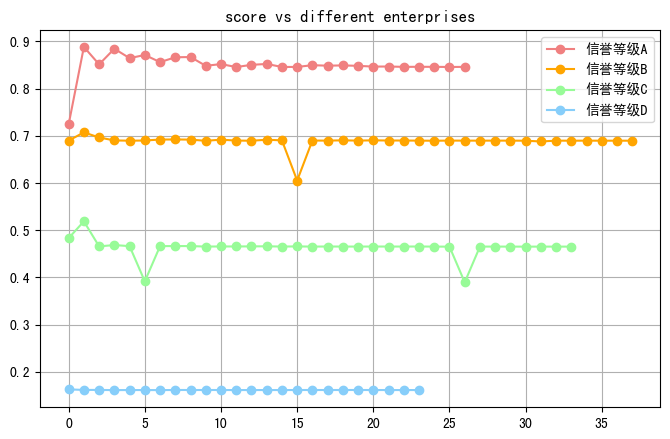

In [78]:
data_temp = data.drop(['企业盈余增长率'], axis = 1)
data_temp['违约得分'] = data1_1['是否违约'].apply(lambda x: 2 if x == 0 else 1)

w = cal_weight(data_temp)[0].tolist()
s = TOPSIS(data_temp,w)

# 绘制出不同等级的得分情况
plt.figure(figsize=(8,5),dpi=100)
list_s = [10,7,4,0]
cset = ['lightcoral','orange','palegreen','lightskyblue']
labels = ['信誉等级A','信誉等级B','信誉等级C','信誉等级D']
for i in range(4):
    idx = data_temp[data_temp['信誉评级得分']==list_s[i]].index.tolist()
    plt.plot(range(len(idx)),s[idx],'-o',c=cset[i],label=labels[i])
plt.title('score vs different enterprises',style='italic')
plt.legend()
plt.grid()
plt.show()


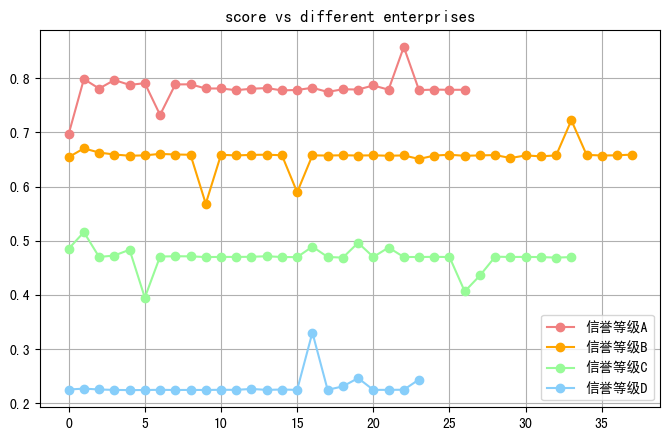

In [79]:
data_temp = data.copy()
# 设置分段函数
def stepfunc(x, sheshold):
  if x > 0: return sheshold + np.log(x - sheshold)
  else: return -sheshold - np.log(-x - sheshold)

data_temp['企业盈余增长率'] = data_temp['企业盈余增长率'].apply(lambda x: x if x <= 450 and x >= -450 else stepfunc(x, 450))

data_temp['违约得分'] = data1_1['是否违约'].apply(lambda x: 2 if x == 0 else 1)

w = cal_weight(data_temp)[0].tolist()
s = TOPSIS(data_temp,w)

# 绘制出不同等级的得分情况
plt.figure(figsize=(8,5),dpi=100)
list_s = [10,7,4,0]
cset = ['lightcoral','orange','palegreen','lightskyblue']
labels = ['信誉等级A','信誉等级B','信誉等级C','信誉等级D']
for i in range(4):
    idx = data_temp[data_temp['信誉评级得分']==list_s[i]].index.tolist()
    plt.plot(range(len(idx)),s[idx],'-o',c=cset[i],label=labels[i])
plt.title('score vs different enterprises',style='italic')
plt.legend()
plt.grid()
plt.show()


确实效果真的蛮一般的，其实还有可能是特征找少了，可以尝试多去找一些特征，然后用多模型把效果垒起来，谢哥的思路是先弄个评价模型得到评分再转换为违约概率，评价模型本身就相当于提取特征吧，然后利用这个特征去找和违约的关系，这一套流程下来其实说白了就是人工的方法，下面我会用端到端的思路，直接对违约概率进行建模，就是套各种模型看看效果如何：

In [82]:
data['违约'] = data1_1['是否违约']
data

,违约得分,信誉评级得分,企业守信度,企业营业额,企业盈余增长率,违约
0,5,10,0.970208,-1.418417e+09,-0.120078,0
1,5,10,0.969476,4.063511e+08,0.265757,0
2,5,4,0.846377,4.294111e+08,-0.155133,0
3,5,4,0.980495,1.348229e+09,-0.506116,0
4,5,7,0.983781,3.735886e+06,-15.515429,0
...,...,...,...,...,...,...
118,1,0,0.997619,-1.551409e+05,88.528348,1
119,1,0,0.935385,1.681682e+05,-0.331950,1
120,1,0,0.980508,-8.072160e+05,-0.133322,1
121,1,0,0.925281,9.505080e+03,0.817297,1


In [83]:
# 先划分数据集
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data.values[:,:-1],data.values[:,-1],random_state=30)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error,r2_score,f1_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from imblearn.combine import SMOTETomek   # 过采样+欠采样结合的方法处理非平衡数据集

fontManager.addfont('SimHei .ttf')
mpl.rc('font', family='SimHei')

smote_tomek = SMOTETomek(random_state=0)
X_train, Y_train = smote_tomek.fit_resample(X_train, Y_train)

param_grid = {'n_estimators': [25,50,100,120],
              'max_depth': [1,2,4,6]}
xgb = xgb.XGBRegressor()
gsearch = GridSearchCV(xgb, param_grid=param_grid, cv=5)
gsearch.fit(X_train,Y_train)

xgb_model = gsearch.best_estimator_
y_pred = xgb_model.predict(X_test)
# print(gsearch.best_params_)
print("r2_score:",r2_score(Y_test, y_pred))


In [90]:
xgb_model.predict(data.values[:,:-1])

array([8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       9.9991655e-01, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 9.9991655e-01,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       9.9991655e-01, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 9.9991655e-01,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e-05,
       8.3625317e-05, 8.3625317e-05, 8.3625317e-05, 8.3625317e

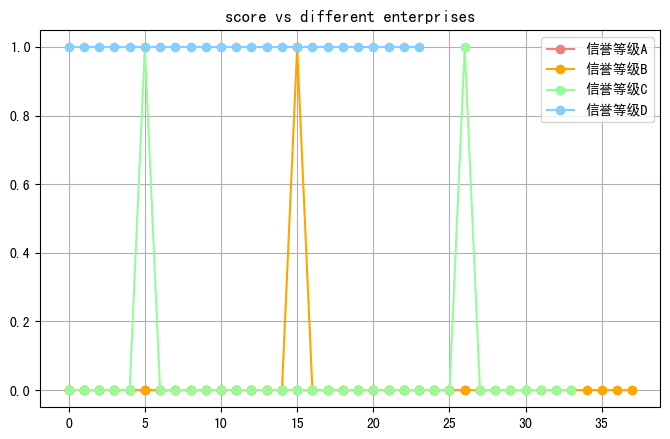

In [92]:
# 绘制出不同等级的得分情况
s = xgb_model.predict(data.values[:,:-1])
plt.figure(figsize=(8,5),dpi=100)
list_s = [10,7,4,0]
cset = ['lightcoral','orange','palegreen','lightskyblue']
labels = ['信誉等级A','信誉等级B','信誉等级C','信誉等级D']
for i in range(4):
    idx = data_temp[data_temp['信誉评级得分']==list_s[i]].index.tolist()
    plt.plot(range(len(idx)),s[idx],'-o',c=cset[i],label=labels[i])
plt.title('score vs different enterprises',style='italic')
plt.legend()
plt.grid()
plt.show()


可以看到xgb因为是树的结构所以实际上得到的效果不是特别理想，还是谢哥的那种拟合的思路比较适用

根据附件3的贷款年利率和流失量建立拟合

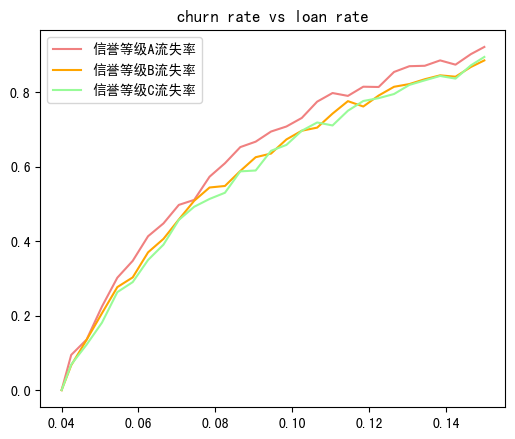

In [93]:
data3_cols = data3.columns
x_3 = data3.iloc[:,0].values # 其实就是取第一列
y_3_list = []
y_3_label = ['信誉等级A流失率','信誉等级B流失率','信誉等级C流失率']
plt.figure(figsize=(6,5),dpi=100)
for idx,i in enumerate(data3_cols[1:]):
    temp = data3[i].values
    y_3_list.append(temp)
    plt.plot(x_3, temp, cset[idx], label=y_3_label[idx])
plt.title('churn rate vs loan rate',style='italic')
plt.legend()
plt.show()

0.0061466208907409595
0.00048286678712497575
0.000155717399279879
0.0048344253194471725
0.0003576471578060272
0.00011426584256516218
0.004290873740271609
0.0003246426358419435
0.00012178039648581349


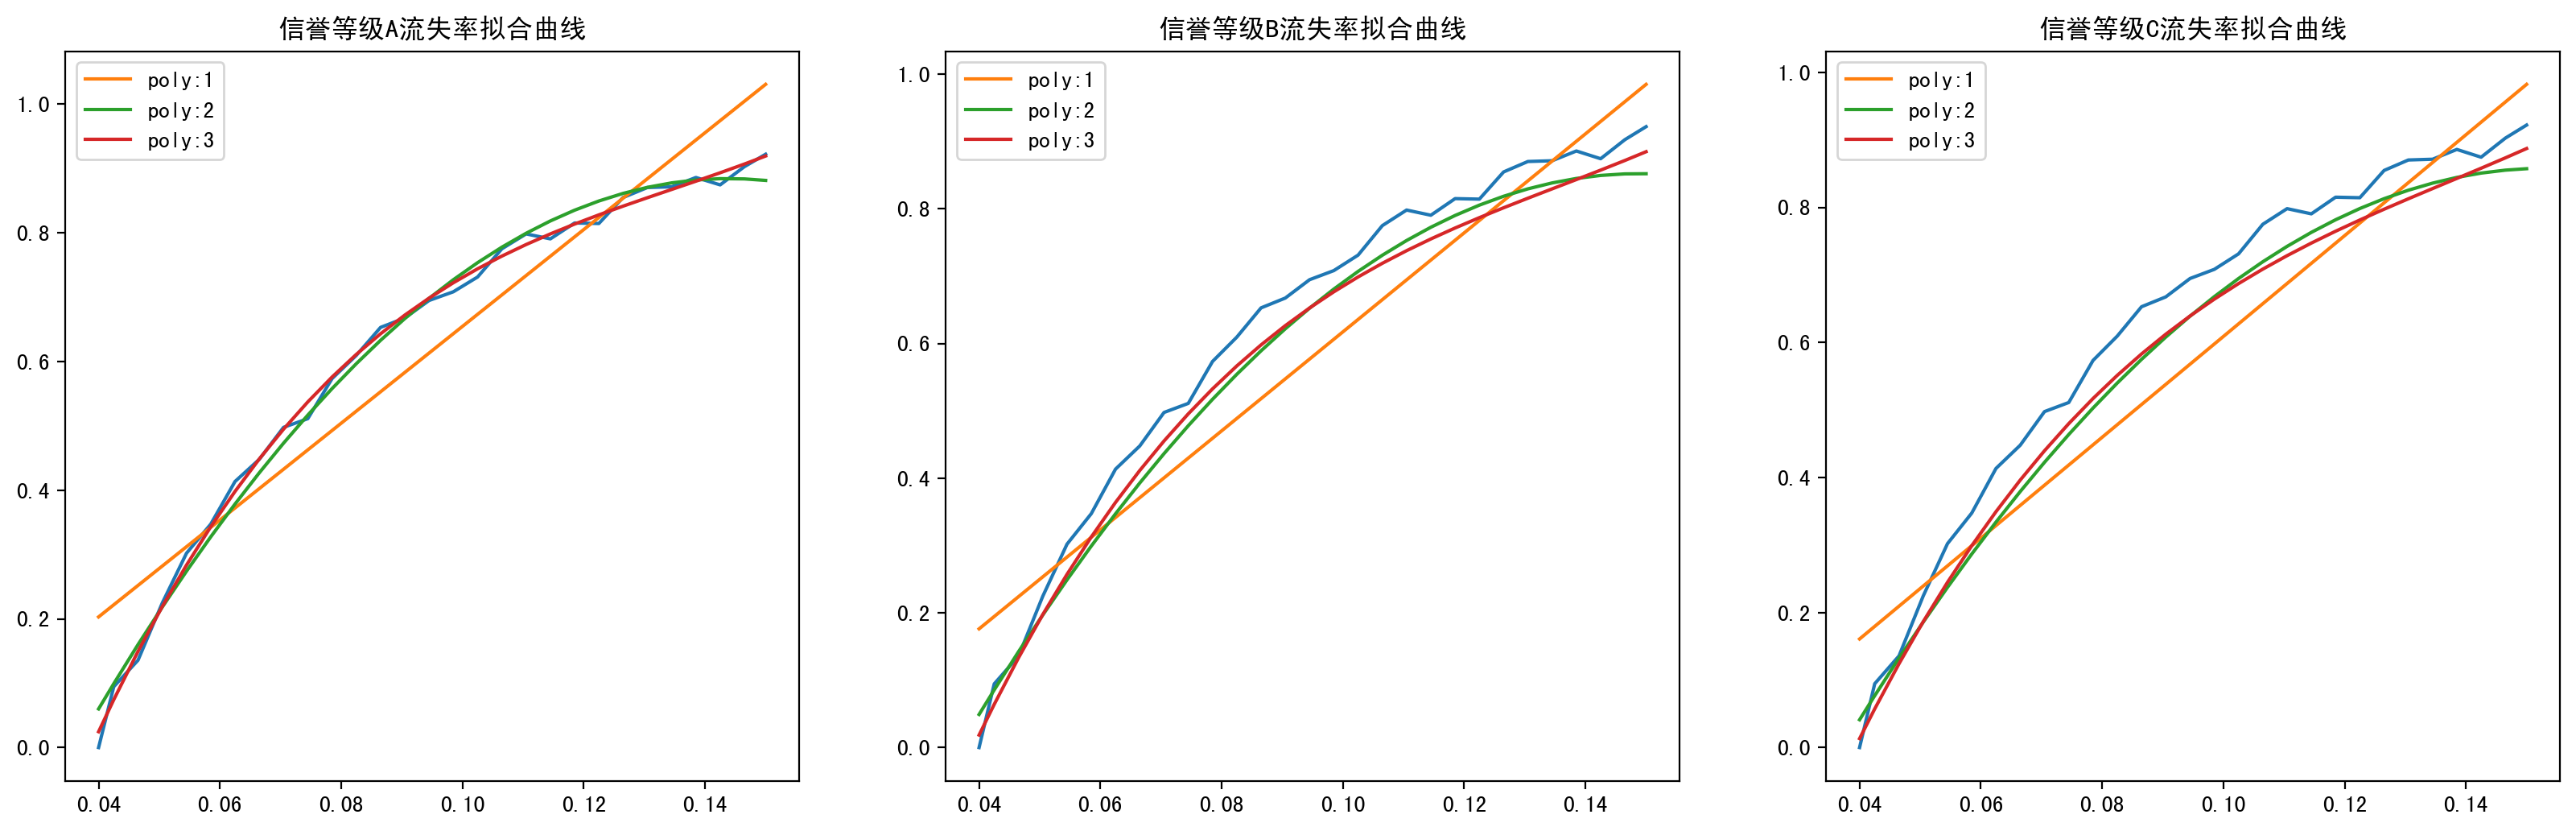

123

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def PolynomialRegression(degree):
    return Pipeline([('poly', PolynomialFeatures(degree=degree)),
                     ('std_scaler', StandardScaler()),
                     ('lin_reg', LinearRegression())])

plt.figure(figsize=(20,6),dpi=200)
model_list = []
for idx in range(3):
    
    x_3_temp = np.array(x_3).reshape((-1,1))
    plt.subplot(1,3,idx+1)
    plt.title('{}拟合曲线'.format(y_3_label[idx]))
    plt.plot(x_3_temp, y_3_list[0])
    for i in range(1,4):
        poly_reg = PolynomialRegression(degree=i)
        poly_reg.fit(x_3_temp, y_3_list[idx])
        y2_pred = poly_reg.predict(x_3_temp)
        plt.plot(x_3_temp, y2_pred, label='poly:{}'.format(i))
        print(mean_squared_error(y2_pred, y_3_list[idx]))
        
        if i == 3:
            model_list.append(poly_reg)
    plt.legend()
plt.show()

dict3 = {'A':0,'B':1,'C':2,'D':3}
lk_classify = data1_1['信誉评级'].apply(lambda x: dict3[x]).values.tolist()
lk_model_list = []
for i in lk_classify:
    if i == 3:
        lk_model_list.append(0)
    else:
        lk_model_list.append(model_list[i])

# 对于D类型的不贷款
def get_index1(lst=None, item=''):
    return [index for (index,value) in enumerate(lst) if value != item]

D_index = get_index1(lk_classify, item=3)
len(lk_model_list)

## 1.3 遗传算法+罚函数求解问题

观察图像和拟合情况,选用3次曲线进行拟合

这里每个企业的违约率$m_i$已经通过前面求出,$W=\sum_{i=1}^{n} [a_i\cdot r\cdot(1-m_i)-a_i\cdot m_i\cdot(1-l_k)]  $

对于不同的信誉等级k,l_k是关于r,k的方程,目前自变量为a_i,r,其约束条件如下

* $10\le a_i\le 100$
* $0.04\le r \le 0.15$
* $\sum a_i \le A$
* $l_r$满足三次拟合函数

使用罚函数+遗传算法解决问题

In [ ]:
"""============================目标函数============================"""
m_list = y2[D_index]  # y2为预测的违约率

lk_model = []
for i in D_index:
    lk_model.append(lk_model_list[i])


def aim(Phen, NIND):  # 传入种群染色体矩阵解码后的基因表现型矩阵
    
    r = Phen[:,0]
    a = np.zeros((NIND,99))
    for i in range(1,100):
        a[:,i-1] = Phen[:,i]
    
    lk_list = np.zeros((NIND,99))
    
    for n in range(NIND):
        for i in range(99):
            if lk_model[i] != 0:
                temp_r = r[n]
                temp_r = np.array([temp_r]).reshape((-1,1))
                lk_list[n][i] = lk_model[i].predict(temp_r)
            else:
                lk_list[n][i] = 0
    
    temp_sum = np.zeros((NIND,1))
    
    penalty = np.sum(a,axis=1)
    penalty_idx = [i for i,j in enumerate(penalty) if j > 5000]
    penalty_num = np.zeros((NIND,1))
    penalty_num[penalty_idx] = 100000  # 为超过定额的部分设置惩罚项
    
    for n in range(NIND):
        for i in range(99):
            o1 = a[n][i]*r[n]*(1-m_list[i]) - a[n][i]*m_list[i]
            o2 = 1 - lk_list[n][i]
            o = o1 * o2
            temp_sum[n] = temp_sum[n] + o
        temp_sum[n] = temp_sum[n] - penalty_num[n]
    
            
    return -temp_sum

"""============================变量设置============================"""
r_range = [0.04,0.15]  # 第一个决策变量范围
a1_range = [10, 100]  # 第二个决策变量范围
# a2_range = [0,1]  # D类型不贷款
b1 = [1, 1]  # 第一个决策变量边界，1表示包含范围的边界，0表示不包含
# b2 = [1, 0]  # 设置D类决策上限

# 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界
ranges = r_range
counter = 0
for i in range(99):
    ranges = np.vstack([ranges, a1_range])
ranges = ranges.T

# 生成自变量的边界矩阵
borders = b1
counter = 0
for i in range(99):
    borders = np.vstack([borders, b1])
borders = borders.T

varTypes = np.array([0]+[1]*99)  # 决策变量的类型，0表示连续，1表示离散

"""==========================染色体编码设置========================="""
Encoding = 'BG'  # 'BG'表示采用二进制/格雷编码
codes = [1]*100  # 决策变量的编码方式，两个1表示变量均使用格雷编码
precisions = [2]*100  # 决策变量的编码精度，表示解码后能表示的决策变量的精度可达到小数点后6位
scales = [0]*100  # 0表示采用算术刻度，1表示采用对数刻度#调用函数创建译码矩阵
FieldD = ea.crtfld(Encoding, varTypes, ranges, borders, precisions, codes, scales)

"""=========================遗传算法参数设置========================"""
NIND = 20  # 种群个体数目
MAXGEN = 1000  # 最大遗传代数
maxormins = np.array([1])  # 表示目标函数是最小化，元素为-1则表示对应的目标函数是最大化
selectStyle = 'sus'  # 采用随机抽样选择
recStyle = 'xovdp'  # 采用两点交叉
mutStyle = 'mutbin'  # 采用二进制染色体的变异算子
Lind = int(np.sum(FieldD[0, :]))  # 计算染色体长度
pc = 0.9  # 交叉概率
pm = 1 / Lind  # 变异概率
obj_trace = np.zeros((MAXGEN, 2))  # 定义目标函数值记录器
var_trace = np.zeros((MAXGEN, Lind))  # 染色体记录器，记录历代最优个体的染色体

"""=========================开始遗传算法进化========================"""
start_time = time.time()  # 开始计时
Chrom = ea.crtpc(Encoding, NIND, FieldD)  # 生成种群染色体矩阵
variable = ea.bs2ri(Chrom, FieldD)  # 对初始种群进行解码
ObjV = aim(variable,NIND)  # 计算初始种群个体的目标函数值
best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号

# 开始进化
for gen in range(MAXGEN):
    FitnV = ea.ranking(maxormins * ObjV)  # 根据目标函数大小分配适应度值
    SelCh = Chrom[ea.selecting(selectStyle, FitnV, NIND - 1), :]  # 选择
    SelCh = ea.recombin(recStyle, SelCh, pc)  # 重组
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm)  # 变异
    # #把父代精英个体与子代的染色体进行合并，得到新一代种群
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    Phen = ea.bs2ri(Chrom, FieldD)  # 对种群进行解码(二进制转十进制)
    ObjV = aim(Phen, NIND)  # 求种群个体的目标函数值
    # 记录
    best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号
    obj_trace[gen, 0] = np.sum(ObjV) / ObjV.shape[0]  # 记录当代种群的目标函数均值
    obj_trace[gen, 1] = ObjV[best_ind]  # 记录当代种群最优个体目标函数值
    var_trace[gen, :] = Chrom[best_ind, :]  # 记录当代种群最优个体的染色体
    # 进化完成
    end_time = time.time()  # 结束计时
# ea.trcplot(obj_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])  # 绘制图像

"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD)  # 解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x' + str(i + 1) + '=', variable[0, i])

print('用时：', end_time - start_time, '秒')

# 问题二 

## 2.1 构建企业信誉等级预测体系

根据企业的3个指标,营业额,增长率,作废的发票率,使用RF进行模型构建,预测未分级的301家企业的信誉等级

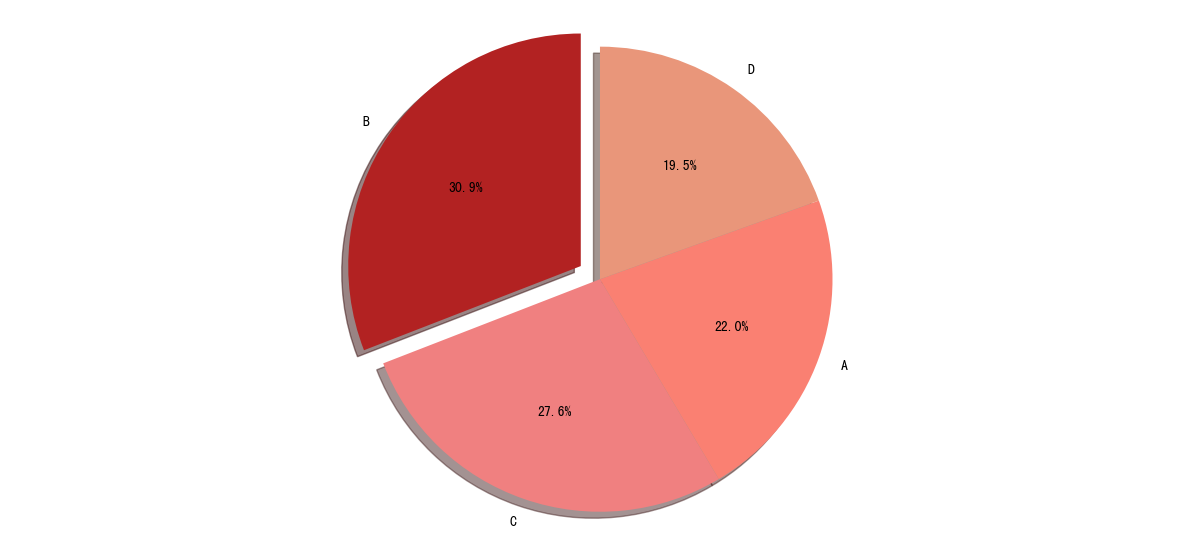

In [97]:
X = data[['企业守信度','企业营业额','企业盈余增长率']].values
dict5 = {'A':3,'B':2,'C':1,'D':0}
m = data1_1['信誉评级']
plot_data = m.value_counts().reset_index()
plot_data.columns=['信誉等级','count']

fig=plt.figure(figsize=(15,7),facecolor='white',dpi=100)

ax0=fig.add_subplot(1,1,1)

colormap1=['firebrick','LightCoral','Salmon','DarkSalmon']

ax0.pie(plot_data['count'], explode=[0.1,0,0,0], autopct='%1.1f%%',labels=plot_data['信誉等级'],
        shadow=True, startangle=90,colors=colormap1)
ax0.axis('equal')
plt.show()

y = data1_1['信誉评级'].apply(lambda x: dict5[x]).values

In [98]:
def run(X,y):
    for i in range(X.shape[1]):
        X[:,i] = scale(X[:,i])
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=True)
    param_grid = {
        'n_estimators':[5,6,7],
        'min_samples_split':[1,2,3,4,5],
        'max_depth':[5,6,7,8,9,10],
        'max_features':[1,2,3,4,5,6]
    }

    clf = GridSearchCV(RandomForestClassifier(random_state=0),param_grid,cv=5)
    clf.fit(X_train,y_train)
    print('train accuracy = ', accuracy_score(clf.predict(X_train), y_train))  
    print('test accuracy = ', accuracy_score(clf.predict(X_test), y_test))
    print(clf.best_params_)
    return X_train,X_test,y_train,y_test,clf

train accuracy =  0.7959183673469388
test accuracy =  0.44
{'max_depth': 8, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 7}


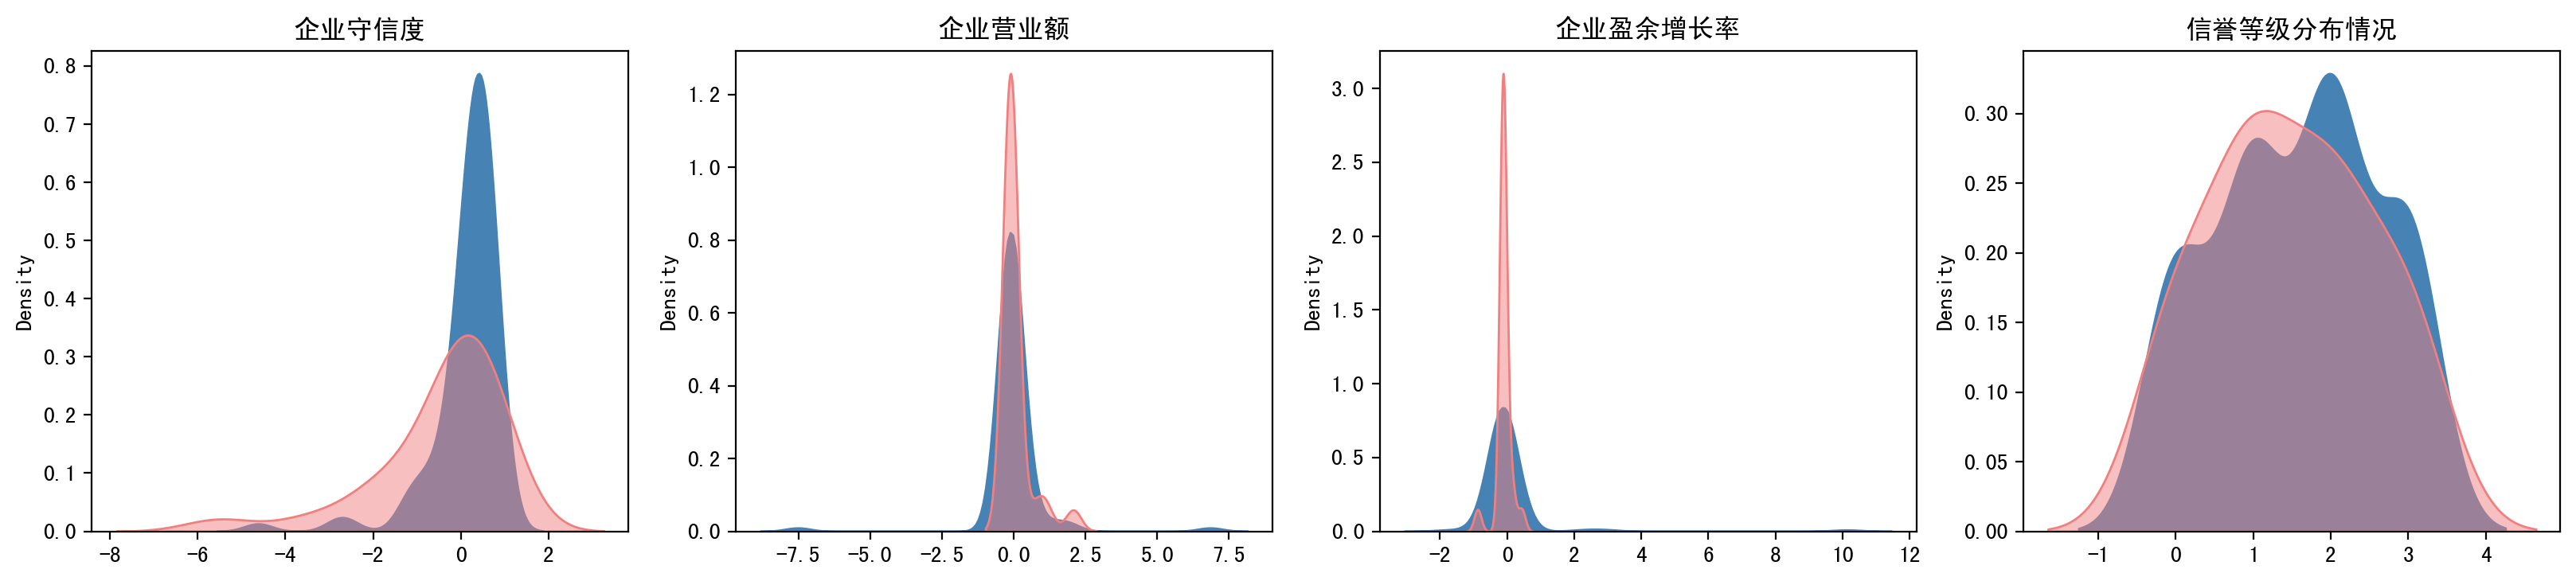

In [99]:
X_train,X_test,y_train,y_test,clf = run(X,y)

plt.figure(figsize=(20,4),dpi=200)
labels = ['企业守信度','企业营业额','企业盈余增长率']
# 查看测试集,训练集样本分布,样本分布不是很匹配,且数据集的样本数和特征比较少
for i in range(3):
    plt.subplot(1,4,i+1)
    plt.title('{}'.format(labels[i]))
    sns.kdeplot(X_train[:,i],color='steelblue', shade=True, alpha=1)
    sns.kdeplot(X_test[:,i],color='lightcoral', shade=True, alpha=0.5)
plt.subplot(1,4,4)
plt.title('信誉等级分布情况')
sns.kdeplot(y_train,color='steelblue', shade=True, alpha=1)
sns.kdeplot(y_test,color='lightcoral', shade=True, alpha=0.5)
plt.show()


这里谢哥是直接用了boxcox，其实这种峰值偏右的分布应该用log去处理，会好些

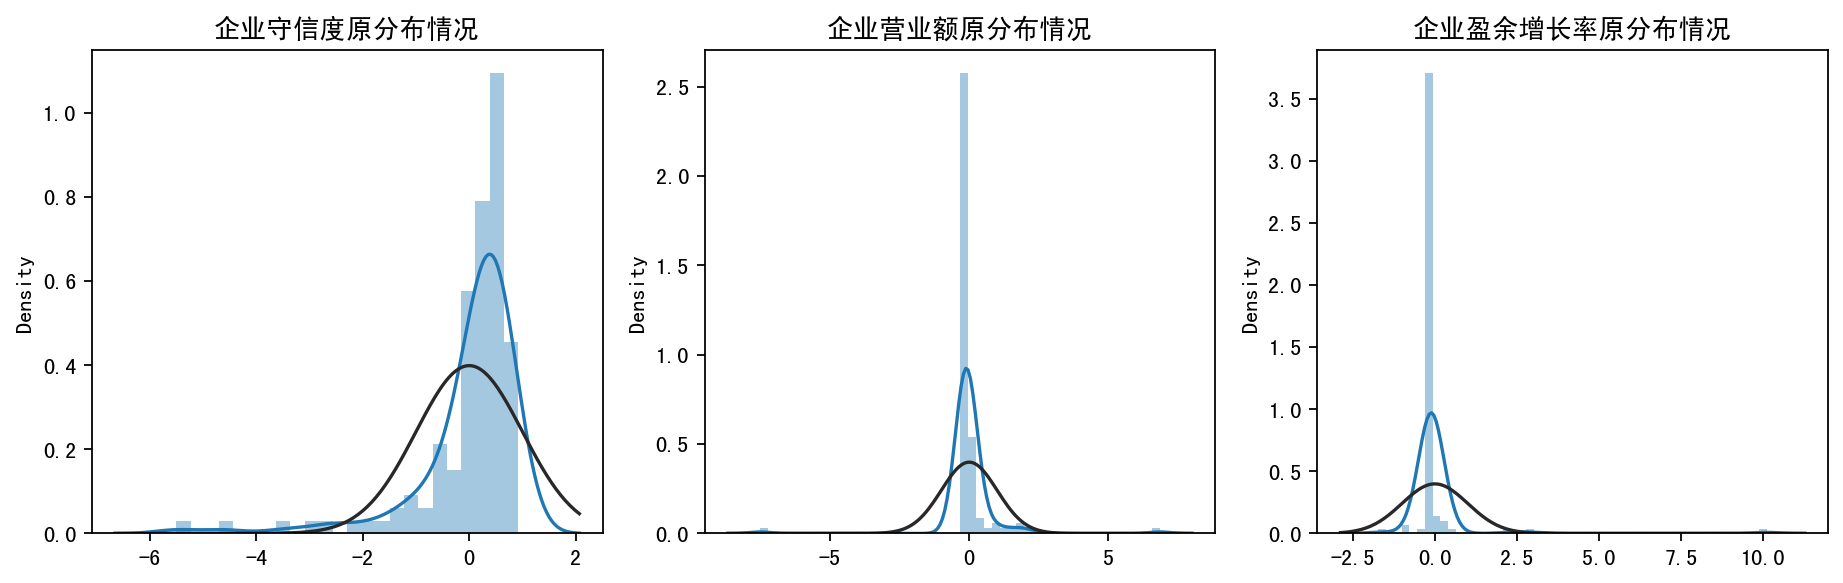

In [100]:
# 怀疑是原分布不符合正态分布,查看原来数据分布
# 使用boxcox转换后效果并没有提升
plt.figure(figsize=(14,4), dpi=160)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title('{}原分布情况'.format(labels[i]))
    sns.distplot(X[:,i],fit=norm)
plt.show()

这里可以考虑欠采样、stacking之类的方法:

In [101]:
pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.combine import SMOTETomek   # 过采样+欠采样结合的方法处理非平衡数据集

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

In [114]:
X1 = data[['企业守信度','企业营业额','企业盈余增长率']].values
X2 = data1_1[['销项额度','销项税额','进项额度','进项税额']].values
X3 = (data1_1['销项税额']/data1_1['销项额度']).values[:, np.newaxis]
X4 = (data1_1['进项税额']/data1_1['进项额度']).values[:, np.newaxis]
# X5 = ((data1_1['销项额度']-data1_1['进项额度'])/(data1_1['销项额度']-data1_1['进项额度'])).values[:, np.newaxis]
X = np.hstack([X1,X2,X3,X4])
y = y.reshape(-1, 1)

In [115]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=30)
smote_tomek = SMOTETomek(random_state=0)
x_train, y_train = smote_tomek.fit_resample(x_train, y_train)

In [116]:
tranfer = StandardScaler()
x = tranferfit_transform.(X)
x_train = tranfer.transform(x_train)
x_test = tranfer.transform(x_test)

In [130]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(learning_rate=0.05,n_estimators=100,objective='multiclass',
                           boosting_type='gbdt',
                           num_leaves=2**5,
                           max_depth=5,reg_alpha=0.5,reg_lambda=0.5,
                           subsample=0.75)

Ada = ada(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=30)
GBDT = GradientBoostingClassifier(ccp_alpha=0.0, learning_rate=0.7,  max_depth=3)
svc = SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=20, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

rf = RF(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)


sclf = StackingCVClassifier(classifiers=[Ada, GBDT, rf],
                            use_probas=True,
                            meta_classifier=svc,
                            )


In [132]:
sclf = StackingCVClassifier(classifiers=[lgb, GBDT,rf],
                            use_probas=True,
                            meta_classifier=svc,
                            )

zhibiao = {}

# weight = []
for clf, label in zip([ Ada, GBDT, svc, rf, lgb,sclf],
                      [
                       'Ada',
                       'GBDT',
                       'svc',
                       'rf', 'LightGBM','StackingClassifier']):
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
#     print('{}在预测集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_test, y_predict))
#     print('{}在训练集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_train, clf.predict(x_train)))
#     print('{}的综合准确率为：\n'.format(label), metrics.accuracy_score(y, clf.predict(x)))
#     print('{}的Precision为：'.format(label), precision_score(y_test, y_predict))
#     print('{}的Recall为：'.format(label), recall_score(y_test, y_predict))
#     weight.append(tem)
#     print('{}的ROC面积为：'.format(label), metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))
#     print('{}的f1值为：'.format(label), metrics.f1_score(y_test, y_predict))
#     print()
    
    tem_1 = [metrics.accuracy_score(y_train, clf.predict(x_train)),metrics.accuracy_score(y_test, y_predict)]
    zhibiao[label]=tem_1
data2 = pd.DataFrame(data=zhibiao,index=['train_Accuracy','test_Accuracy']).T
data2


,train_Accuracy,test_Accuracy
Ada,0.676471,0.612903
GBDT,1.000000,0.322581
svc,0.970588,0.129032
rf,1.000000,0.516129
LightGBM,0.823529,0.483871
StackingClassifier,0.235294,0.258065


In [136]:
# LGB单模(对非平衡数据集设置is_unbalance)
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=30)
clf = LGBMClassifier(learning_rate=0.05,n_estimators=100,objective='multiclass',
                           boosting_type='gbdt',
                           num_leaves=2**5,
                           max_depth=5,reg_alpha=0.5,reg_lambda=0.5,is_unbalance=True, subsample=0.75)
clf.fit(x_train,y_train)
pd.DataFrame(data=[metrics.accuracy_score(y_train, clf.predict(x_train)),metrics.accuracy_score(y_test, y_predict),
            ],index=['train_Accuracy','test_Accuracy',],columns=['LightGBM']).T

,train_Accuracy,test_Accuracy
LightGBM,0.728261,0.258065


试试XGB，效果确实提上来了

In [140]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve

X_train,X_test,Y_train,Y_test=train_test_split(X,y,random_state=30)
smote_tomek = SMOTETomek(random_state=0)
X_train, Y_train = smote_tomek.fit_resample(X, y)

param_grid = {'n_estimators': [25,50,100,120],
              'max_depth': [1,2,4,6]}
xgb = xgb.XGBClassifier()
gsearch = GridSearchCV(xgb, param_grid=param_grid, cv=5)
gsearch.fit(X_train,Y_train)

xgb_model = gsearch.best_estimator_
y_pred = xgb_model.predict(X_test)
# print(gsearch.best_params_)
print("accuracy_score:",accuracy_score(Y_test, y_pred))
print("Train Score：", accuracy_score(Y_train, xgb_model.predict(X_train)))


accuracy_score: 0.6774193548387096
Train Score： 0.8921568627450981


## 2.2 根据问题1处理提取其余样本各项特征

In [ ]:
data2 = pd.DataFrame()
data2_2 = pd.read_excel('data2_2.xlsx')
data2_3 = pd.read_excel('data2_3.xlsx')


In [ ]:
col = cal_trustworthiness(data2_2, data2_3)
data2['企业守信度'] = 1- col.values

col2 = cal_turnover(data2_2,data2_3,data2)
data2['企业营业额'] = 1 - col2.values

append_index = np.arange(124, 426)
list2 = [0]*302
for i in range(302):
    list2[i] = 'E' + str(append_index[i])
mean_list2 = cal_growth_rate(data2_2,data2_3,list2)
data2['企业盈余增长率'] = mean_list2


data2.head()

,企业守信度,销项额度,销项税额,进项额度,进项税额,企业营业额,企业盈余增长率
0,0.948982,7.417804e+08,6.665738e+07,7.855255e+08,5.867726e+07,5.172529e+07,-0.394742
1,0.953509,9.412114e+08,8.362975e+07,9.323832e+08,6.881856e+07,5.983065e+06,-0.410101
2,0.956759,5.206911e+08,1.731628e+07,1.127735e+08,1.604526e+07,-4.066466e+08,0.234890
3,0.993800,6.519380e+08,1.957022e+07,1.646702e+06,1.188565e+05,-6.308399e+08,-0.067504
4,0.991870,2.423902e+08,8.299067e+06,8.928033e+06,4.324670e+05,-2.255955e+08,0.290830


In [ ]:
X2_1 = data2.values

X2_2 = (data2['销项税额']/data2['销项额度']).values[:, np.newaxis]
X2_3 = (data2['进项税额']/data2['进项额度']).values[:, np.newaxis]

X_2 = np.hstack([X2_1,X2_2,X2_3])

In [ ]:
for i in range(X_2.shape[1]):
    X_2[:,i] = scale(X_2[:,i])
X_2_list = clf_final.predict(X_2)

In [ ]:
data2['信誉打分'] = X_2_list
data2.head()

,企业守信度,销项额度,销项税额,进项额度,进项税额,企业营业额,企业盈余增长率,信誉打分
0,0.948982,7.417804e+08,6.665738e+07,7.855255e+08,5.867726e+07,5.172529e+07,-0.394742,3
1,0.953509,9.412114e+08,8.362975e+07,9.323832e+08,6.881856e+07,5.983065e+06,-0.410101,3
2,0.956759,5.206911e+08,1.731628e+07,1.127735e+08,1.604526e+07,-4.066466e+08,0.234890,3
3,0.993800,6.519380e+08,1.957022e+07,1.646702e+06,1.188565e+05,-6.308399e+08,-0.067504,0
4,0.991870,2.423902e+08,8.299067e+06,8.928033e+06,4.324670e+05,-2.255955e+08,0.290830,1


## 2.3 构建企业信誉得分评价体系

由于问题二与问题一不同,1.信誉等级是通过模型预测的 2.无法获知企业的违约情况

在这种特征比较少的情况下,可以引入其他特征来帮助构建更为完善的评价体系,如使用销项额度和进项额度的规模来衡量企业的规模,进项税额和销项税额来衡量企业的税率偏好,一般情况下可以认为交税越多,规模越大

由于预测的信誉打分不会太准,就不调整其得分分布,防止更大误差出现

In [ ]:
data2['税率偏好'] = ((data2['销项税额'] - data2['进项税额'])/(data2['销项额度']  - data2['进项额度']))
data2  # 出现部分负数情况,搞不懂为什么营业额为负数也要交税,而且还有税率大于1的离谱现象

,企业守信度,销项额度,销项税额,进项额度,进项税额,企业营业额,企业盈余增长率,信誉打分,税率偏好
0,0.948982,7.417804e+08,6.665738e+07,7.855255e+08,5.867726e+07,5.172529e+07,-0.394742,3,-0.182423
1,0.953509,9.412114e+08,8.362975e+07,9.323832e+08,6.881856e+07,5.983065e+06,-0.410101,3,1.677728
2,0.956759,5.206911e+08,1.731628e+07,1.127735e+08,1.604526e+07,-4.066466e+08,0.234890,3,0.003116
3,0.993800,6.519380e+08,1.957022e+07,1.646702e+06,1.188565e+05,-6.308399e+08,-0.067504,0,0.029912
4,0.991870,2.423902e+08,8.299067e+06,8.928033e+06,4.324670e+05,-2.255955e+08,0.290830,1,0.033695
...,...,...,...,...,...,...,...,...,...
297,0.995833,2.457008e+05,7.371070e+03,3.039381e+04,1.776190e+03,-2.097111e+05,0.465212,0,0.025986
298,0.981818,2.701831e+04,8.383000e+02,8.893900e+02,7.061000e+01,-2.536023e+04,15.486992,0,0.029381
299,0.992857,7.278640e+04,2.183600e+03,6.104614e+04,8.005560e+03,-1.756122e+04,-0.019470,0,-0.495897
300,0.945144,7.689642e+04,2.306880e+03,2.543299e+05,1.766949e+04,1.620719e+05,0.783983,0,0.086582


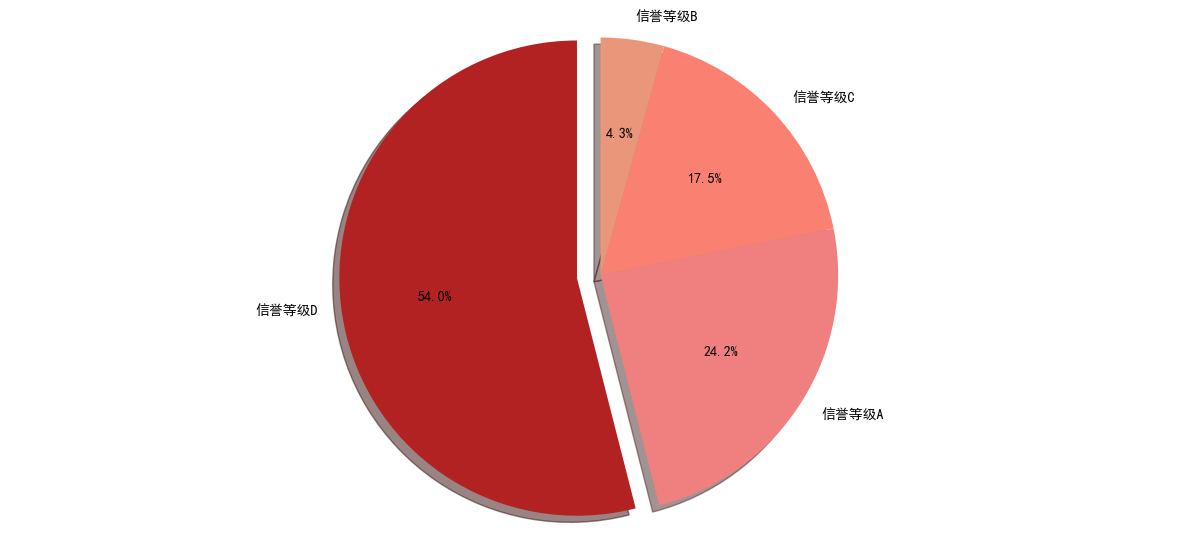

In [ ]:
data2_final = data2[['企业守信度','企业营业额','企业盈余增长率','信誉打分','税率偏好']]

# 可以看到预测的企业中D类型比例占比较大
dict5 = {3:'信誉等级A', 2:'信誉等级B', 1:'信誉等级C', 0:'信誉等级D'}
m = data2_final['信誉打分'].apply(lambda x: dict5[x])
plot_data = m.value_counts().reset_index()
plot_data.columns=['信誉打分','count']

fig=plt.figure(figsize=(15,7),facecolor='white',dpi=100)

ax0=fig.add_subplot(1,1,1)

colormap1=['firebrick','LightCoral','Salmon','DarkSalmon']

ax0.pie(plot_data['count'], explode=[0.1,0,0,0], autopct='%1.1f%%',labels=plot_data['信誉打分'],
        shadow=True, startangle=90,colors=colormap1)
ax0.axis('equal')
plt.show()

In [ ]:
w2 = cal_weight(data2_final)[0].tolist()
s2 = TOPSIS(data2_final,w2)
data2_final['综合评分'] = s2
data2_final.head()

,企业守信度,企业营业额,企业盈余增长率,信誉打分,税率偏好,综合评分
0,0.948982,5.172529e+07,-0.394742,3,-0.182423,0.970696
1,0.953509,5.983065e+06,-0.410101,3,1.677728,0.994470
2,0.956759,-4.066466e+08,0.234890,3,0.003116,0.961214
3,0.993800,-6.308399e+08,-0.067504,0,0.029912,0.050723
4,0.991870,-2.255955e+08,0.290830,1,0.033695,0.336531


这个效果好的原因其实可以从第一文件就能看出来，只要不涉及到偏的违约点，就基本上完全区分开了，而第二问都是用自己的模型来得到的违约概率和打分，自然就不会出现第一问的情况，可以很好的区分开了。

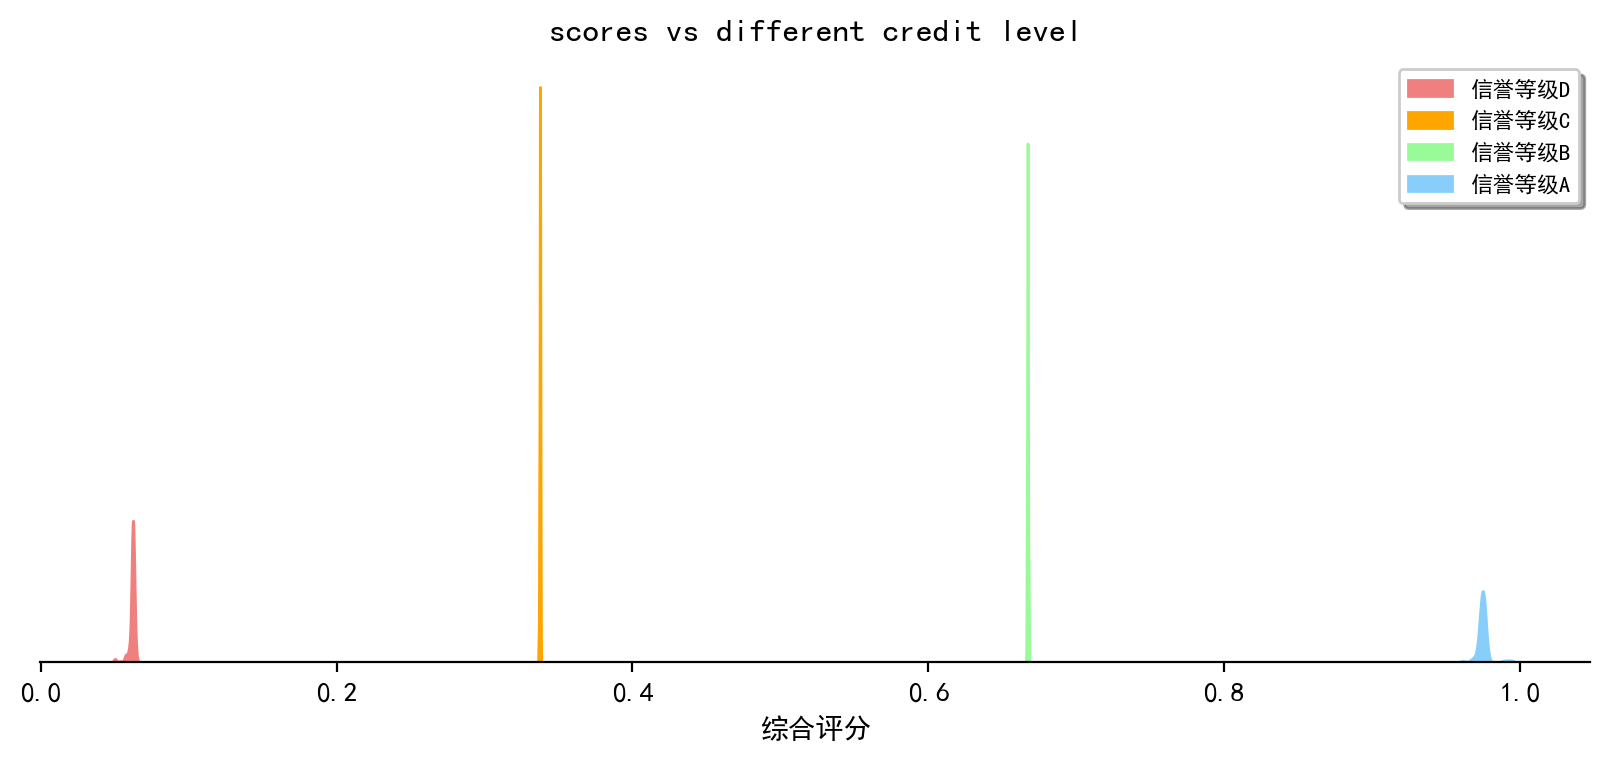

In [ ]:
cset = ['lightcoral','orange','palegreen','lightskyblue']
plt.figure(figsize=(10,4),dpi=200)
tag = ['信誉等级D','信誉等级C','信誉等级B','信誉等级A']

ax = plt.subplot(1,1,1)
for i in range(4):
    sns.kdeplot(data=data2_final[data2_final['信誉打分']==i]['综合评分'],shade=True,color=cset[i],alpha=1,label=tag[i])
#     ax.legend_.remove()
#     ax.set_yticklabels('')
#     ax.set_ylabel('')
#     ax.tick_params(axis='y',length=0)
#     for direction in ['top','right','left']:
#         ax.spines[direction].set_visible(False)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(axis='y',length=0)
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)
plt.title('scores vs different credit level', style='italic')
plt.legend(shadow=True,fontsize=8)
plt.show()

可以看到用熵权+TOPSIS的评价体系,可以较好地将不同信誉等级区分开,接下来预测其违约率

In [ ]:
l2_list = np.array([func(i, popt[0],popt[1],popt[2], popt[3], popt[4]) for i in s2])

lk_classify2 = data2_final['信誉打分'].values.tolist()
lk_model_list2 = []
for i in lk_classify2:
    if i == 0:
        lk_model_list2.append(0)
    else:
        lk_model_list2.append(model_list[3-i])  # A:3,B:2,C:1 ModelA:0 ModelB:1 ModelC:2

# 对于D类型的不贷款
def get_index1(lst=None, item=''):
    return [index for (index,value) in enumerate(lst) if value != item]

D_index2 = get_index1(lk_classify2, item=0)

len(D_index2)

139

使用**罚函数+遗传算法**求解

In [ ]:
"""============================目标函数============================"""
m_list2 = l2_list[D_index2]  # y2为预测的违约率

lk_model2 = []
for i in D_index2:
    lk_model2.append(lk_model_list2[i])

def aim(Phen, NIND):  # 传入种群染色体矩阵解码后的基因表现型矩阵
    
    r = Phen[:,0]
    a = np.zeros((NIND,139))
    for i in range(1,140):
        a[:,i-1] = Phen[:,i]
    
    lk_list = np.zeros((NIND,139))
    
    for n in range(NIND):
        for i in range(139):
            if lk_model2[i] != 0:
                temp_r = r[n]
                temp_r = np.array([temp_r]).reshape((-1,1))
                lk_list[n][i] = lk_model2[i].predict(temp_r)
            else:
                lk_list[n][i] = 0
    
    temp_sum = np.zeros((NIND,1))
    
    penalty = np.sum(a,axis=1)
    penalty_idx = [i for i,j in enumerate(penalty) if j > 10000]  # 1个亿
    penalty_num = np.zeros((NIND,1))
    penalty_num[penalty_idx] = 100000  # 为超过定额的部分设置惩罚项
    
    for n in range(NIND):
        for i in range(139):
            o1 = a[n][i]*r[n]*(1-m_list2[i]) - a[n][i]*m_list2[i]
            o2 = 1 - lk_list[n][i]
            o = o1 * o2
            temp_sum[n] = temp_sum[n] + o
        temp_sum[n] = temp_sum[n] - penalty_num[n]
    
            
    return -temp_sum

"""============================变量设置============================"""
r_range = [0.04,0.15]  # 第一个决策变量范围
a1_range = [10, 100]  # 第二个决策变量范围
# a2_range = [0,1]  # D类型不贷款
b1 = [1, 1]  # 第一个决策变量边界，1表示包含范围的边界，0表示不包含
# b2 = [1, 0]  # 设置D类决策上限

# 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界
ranges = r_range
counter = 0
for i in range(139):
    ranges = np.vstack([ranges, a1_range])
ranges = ranges.T

# 生成自变量的边界矩阵
borders = b1
counter = 0
for i in range(139):
    borders = np.vstack([borders, b1])
borders = borders.T

varTypes = np.array([0]+[1]*139)  # 决策变量的类型，0表示连续，1表示离散

"""==========================染色体编码设置========================="""
Encoding = 'BG'  # 'BG'表示采用二进制/格雷编码
codes = [1]*140  # 决策变量的编码方式，两个1表示变量均使用格雷编码
precisions = [2]*140  # 决策变量的编码精度，表示解码后能表示的决策变量的精度可达到小数点后6位
scales = [0]*140  # 0表示采用算术刻度，1表示采用对数刻度#调用函数创建译码矩阵
FieldD = ea.crtfld(Encoding, varTypes, ranges, borders, precisions, codes, scales)

"""=========================遗传算法参数设置========================"""
NIND = 50  # 种群个体数目
MAXGEN = 200  # 最大遗传代数
maxormins = np.array([1])  # 表示目标函数是最小化，元素为-1则表示对应的目标函数是最大化
selectStyle = 'sus'  # 采用随机抽样选择
recStyle = 'xovdp'  # 采用两点交叉
mutStyle = 'mutbin'  # 采用二进制染色体的变异算子
Lind = int(np.sum(FieldD[0, :]))  # 计算染色体长度
pc = 0.9  # 交叉概率
pm = 1 / Lind  # 变异概率
obj_trace = np.zeros((MAXGEN, 2))  # 定义目标函数值记录器
var_trace = np.zeros((MAXGEN, Lind))  # 染色体记录器，记录历代最优个体的染色体

"""=========================开始遗传算法进化========================"""
start_time = time.time()  # 开始计时
Chrom = ea.crtpc(Encoding, NIND, FieldD)  # 生成种群染色体矩阵
variable = ea.bs2ri(Chrom, FieldD)  # 对初始种群进行解码
ObjV = aim(variable,NIND)  # 计算初始种群个体的目标函数值
best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号

# 开始进化
for gen in range(MAXGEN):
    FitnV = ea.ranking(maxormins * ObjV)  # 根据目标函数大小分配适应度值
    SelCh = Chrom[ea.selecting(selectStyle, FitnV, NIND - 1), :]  # 选择
    SelCh = ea.recombin(recStyle, SelCh, pc)  # 重组
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm)  # 变异
    # #把父代精英个体与子代的染色体进行合并，得到新一代种群
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    Phen = ea.bs2ri(Chrom, FieldD)  # 对种群进行解码(二进制转十进制)
    ObjV = aim(Phen, NIND)  # 求种群个体的目标函数值
    # 记录
    best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号
    obj_trace[gen, 0] = np.sum(ObjV) / ObjV.shape[0]  # 记录当代种群的目标函数均值
    obj_trace[gen, 1] = ObjV[best_ind]  # 记录当代种群最优个体目标函数值
    var_trace[gen, :] = Chrom[best_ind, :]  # 记录当代种群最优个体的染色体
    # 进化完成
    end_time = time.time()  # 结束计时
# ea.trcplot(obj_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])  # 绘制图像

"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD)  # 解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x' + str(i + 1) + '=', variable[0, i])

print('用时：', end_time - start_time, '秒')

最优解的目标函数值： -257.0641419765121
最优解的决策变量值为：
x1= 0.06933333333333333
x2= 76.0
x3= 58.0
x4= 71.0
x5= 97.0
x6= 96.0
x7= 67.0
x8= 97.0
x9= 45.0
x10= 98.0
x11= 82.0
x12= 83.0
x13= 62.0
x14= 75.0
x15= 88.0
x16= 31.0
x17= 51.0
x18= 30.0
x19= 98.0
x20= 13.0
x21= 75.0
x22= 91.0
x23= 99.0
x24= 75.0
x25= 90.0
x26= 83.0
x27= 66.0
x28= 31.0
x29= 80.0
x30= 66.0
x31= 91.0
x32= 70.0
x33= 47.0
x34= 50.0
x35= 77.0
x36= 79.0
x37= 91.0
x38= 86.0
x39= 76.0
x40= 87.0
x41= 54.0
x42= 38.0
x43= 31.0
x44= 42.0
x45= 70.0
x46= 65.0
x47= 69.0
x48= 84.0
x49= 45.0
x50= 55.0
x51= 92.0
x52= 80.0
x53= 74.0
x54= 34.0
x55= 89.0
x56= 43.0
x57= 84.0
x58= 86.0
x59= 84.0
x60= 86.0
x61= 94.0
x62= 50.0
x63= 53.0
x64= 98.0
x65= 91.0
x66= 94.0
x67= 71.0
x68= 81.0
x69= 16.0
x70= 82.0
x71= 94.0
x72= 98.0
x73= 57.0
x74= 89.0
x75= 98.0
x76= 49.0
x77= 98.0
x78= 74.0
x79= 84.0
x80= 75.0
x81= 94.0
x82= 84.0
x83= 100.0
x84= 60.0
x85= 90.0
x86= 98.0
x87= 44.0
x88= 92.0
x89= 96.0
x90= 53.0
x91= 94.0
x92= 62.0
x93= 48.0
x94= 91.0
x95= 55.0
x

# 问题三

## 3.1 风险模型构建

首先要将企业进行类别分类,同时也要考虑到不同的风险,通过人为或者查询资料打分,构建出不同企业对各类风险的应对矩阵

可以将风险分为;疫情等突发卫生情况,极端天气(造成运输堵塞,工程进度延缓,养殖业危机),金融危机(造成外贸,科技等企业出现财务危机)

In [ ]:
import re # 正则表达式库
import collections # 词频统计库
import wordcloud# 词云展示库
from PIL import Image # 图像处理库
import matplotlib.pyplot as plt# 图像展示库
import jieba
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

df = pd.read_excel('data2.xlsx')
words = df['企业名称'].values.tolist()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\020227\AppData\Local\Temp\jieba.cache
Loading model cost 1.269 seconds.
Prefix dict has been built successfully.


[('个体经营', 56), ('建筑', 25), ('科技', 24), ('劳务', 14), ('建设', 13), ('装饰', 12), ('商贸', 12), ('服务', 12), ('设备', 10), ('文化', 10), ('设计', 10), ('机械', 8), ('物流', 8), ('网络', 6), ('贸易', 6), ('技术', 6), ('管理', 6), ('咨询', 5), ('建材', 5), ('传播', 5), ('备有', 5), ('营销', 5), ('营销策划', 5), ('策划', 5), ('广告', 5), ('材料', 4), ('医疗', 4), ('发展', 4), ('机电', 4), ('通信', 4), ('食品', 3), ('运', 3), ('业', 3), ('电子', 3), ('汽车', 3), ('信息', 3), ('机电设备', 3), ('电设备', 3), ('环保', 3), ('电器', 3)]


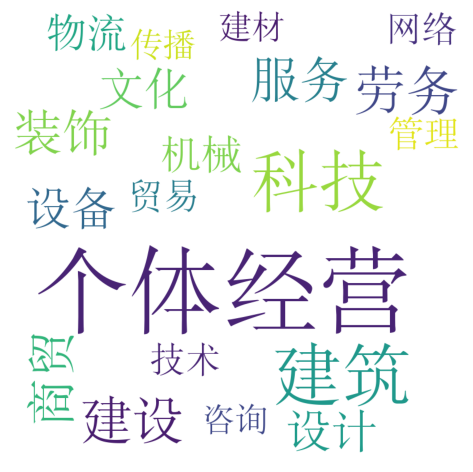

In [ ]:
object_list = []
remove_words = ['',' ', '有限公司', '责任公司','公司','有限','有限责任','营部','建设工程','建筑工程','工程',
                '计有','个体','经营','责任','厂','分公司','中心','店','*','***', '经营部','合作社']

text = [0]*302

# 去除字母和数字
for i in range(len(words)):
    text[i] = words[i]
    for ch in text[i]:
        if ch <= '9' and ch >= '0':
            text[i] = text[i].replace(ch, " ")
        if ch <= 'Z' and ch >= 'A':
            text[i] = text[i].replace(ch, " ")
        if ch == '*':
            text[i] = text[i].replace(ch, "")
    all_words = jieba.cut(text[i],cut_all=True)
    for word in all_words:
        if word not in remove_words:
            object_list.append(word)
# 统计词频
word_counts = collections.Counter(object_list) # 对分词做词频统计
word_counts_top15 = word_counts.most_common(20) # 获取前10最高频的词
print (word_counts.most_common(40)) # 输出检查

plt.figure(figsize=(8,6),dpi=100)
# 词频展示
wc = wordcloud.WordCloud(
    width=800,
    height = 800,
    max_words=20, # 最多显示词数
    font_path="test_font.ttf",
    background_color= 'white',margin=3 )

wc.generate_from_frequencies(word_counts) 
plt.imshow(wc) 
plt.axis('off') 
plt.show() 


首先将302个企业大致分为23个类别,为每个类别设置风险承受因子,同时为每个风险设置一定的风险概率,结合之前的信誉得分,可以达到适当降低其信誉得分的效果,进而增高其违约率,从而使得银行更新信贷策略

In [ ]:
cate =['个体经营','建筑','科技','劳务','建设','装饰','商贸','服务','设备','文化','设计',
       '机械','物流','网络','贸易','管理','建材','广告','医疗','通信','食品','汽车','其他']

cate_list = [0]*302
for i in range(len(text)):
    for idx,j in enumerate(cate):
        if j in text[i]:
            cate_list[i] = idx
            break
        if idx == 22:
            cate_list[i] = 22

ser = pd.Series(cate_list)
cate_np = np.array(cate)

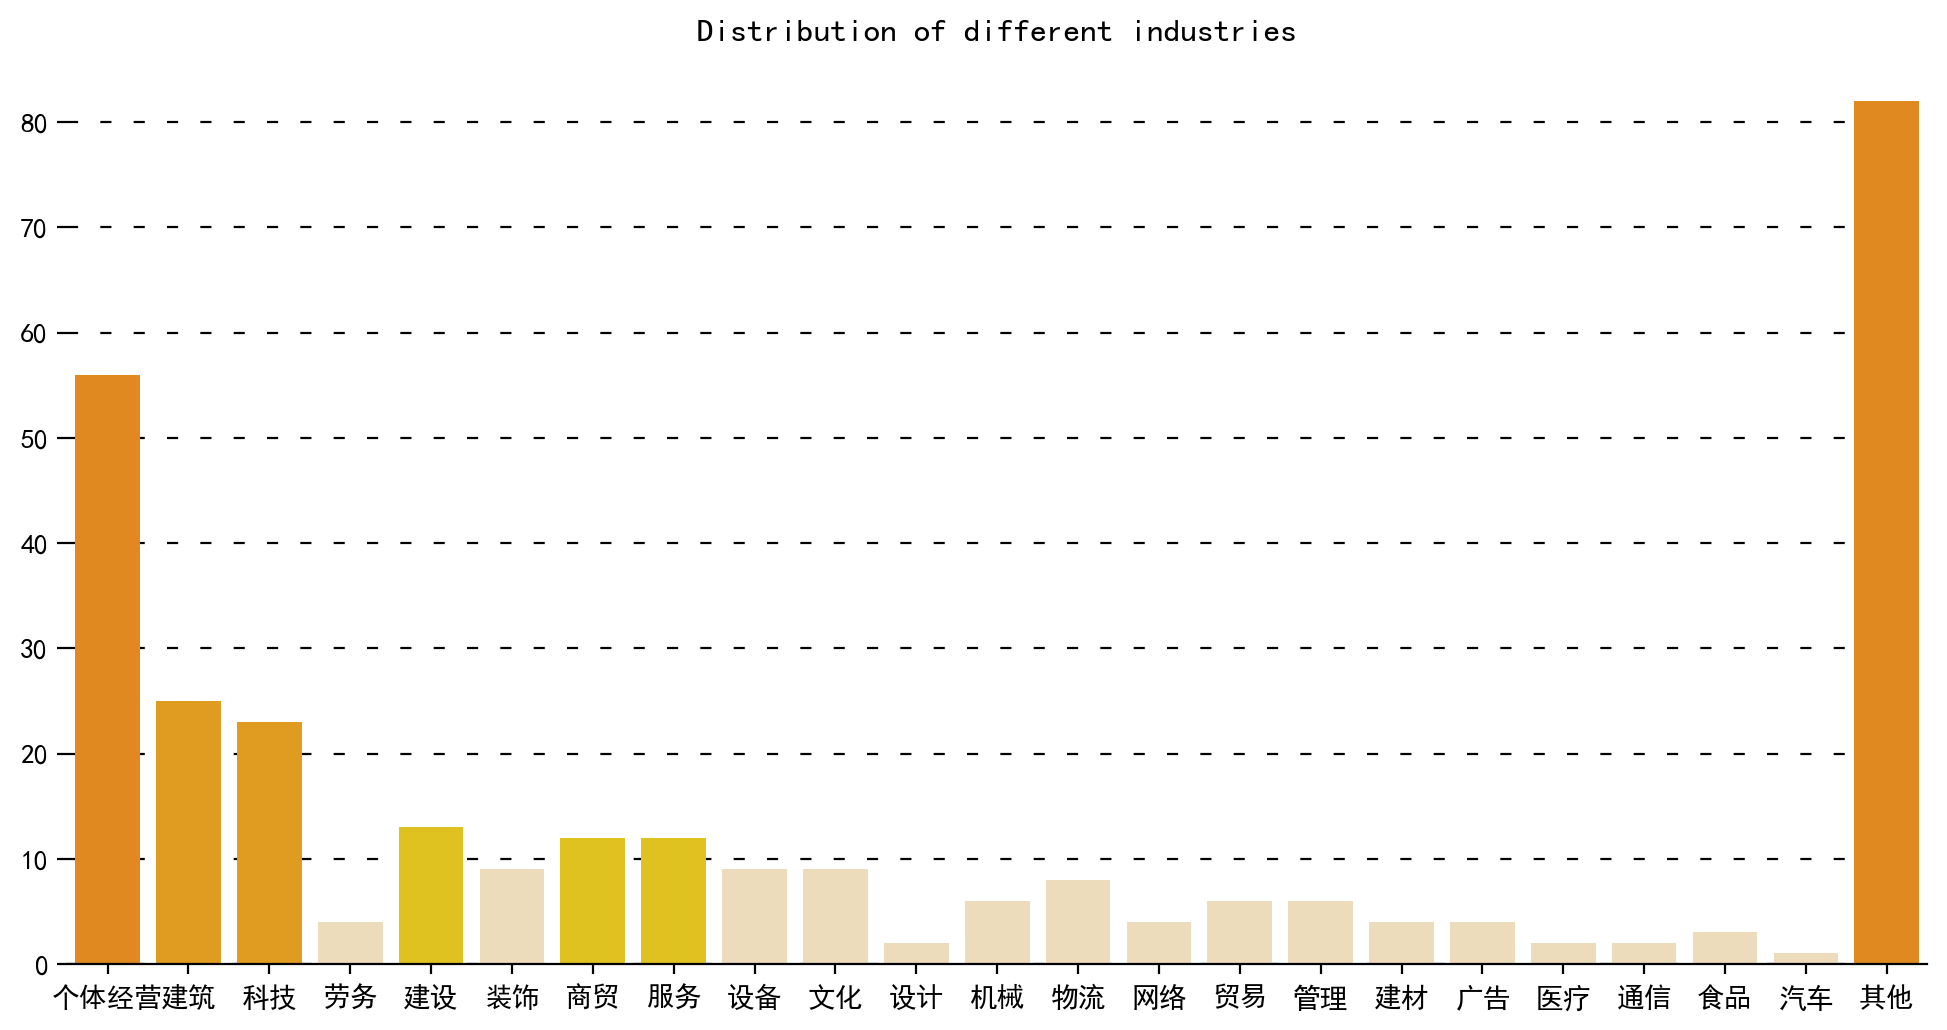

In [ ]:
plt.figure(figsize=(12,6),dpi=200)
ax = plt.subplot(1,1,1)

palette1=["wheat" for _ in range(22)]
palette1[0] = "darkorange"
palette1[1] = "orange"
palette1[2] = "orange"
palette1[4] = "gold"
palette1[6] = "gold"
palette1[7] = "gold"

plt.title('Distribution of different industries')
sns.barplot(y=ser.value_counts().sort_index().values,
              x=cate,palette=palette1,zorder=2)

ax.grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(5,10))
ax.set_ylabel('')
ax.set_xlabel('')
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)
    
plt.show()

首先针对不同风险构造影响程度矩阵,风险有:**疫情等突发卫生情况,极端天气(洪灾/暴雨/台风/冰雹, 干旱),金融危机**,共3大类,4小类(极端天气分为两类),现在针对各种突发状况对不同产业进行影响程度打分,其他类别为其他行业的均值

|          | 疫情等突发卫生情况 | 极端天气 | 金融危机 |
| :------- | :----------------: | :------: | :------: |
| 个体经营 |         8          |    5     |    5     |
| 建筑     |         2          |    7     |    3     |
| 科技     |         1          |    1     |    8     |
| 劳务     |         8          |    2     |    2     |
| 建设     |         2          |    7     |    4     |
| 装饰     |         2          |    2     |    2     |
| 商贸     |         5          |    7     |    8     |
| 服务     |         8          |    8     |    5     |
| 设备     |         1          |    1     |    2     |
| 文化     |         2          |    2     |    2     |
| 设计     |         2          |    2     |    2     |
| 机械     |         2          |    2     |    2     |
| 物流     |         8          |    8     |    5     |
| 网络     |         2          |    2     |    7     |
| 贸易     |         7          |    8     |    8     |
| 管理     |         2          |    2     |    2     |
| 建材     |         2          |    5     |    5     |
| 广告     |         2          |    2     |    2     |
| 医疗     |         8          |    2     |    2     |
| 通信     |         2          |    2     |    5     |
| 食品     |         7          |    5     |    2     |
| 汽车     |         5          |    2     |    5     |
| 其他     |         4          |   3.82   |    4     |




根据风险影响程度矩阵对每个行业进行风险评级打分,这里同样使用TOPSIS+熵权构造得分矩阵,然后用原来的得分结合风险评级打分,得到最后的信用综合评分

In [ ]:
factor = np.array([[8.0, 5.0, 5.0], [2, 7, 3], [1, 1, 8],
                   [8, 2, 2], [2, 7, 4], [2, 2, 2],
                   [5, 7, 8], [8, 8, 5], [1, 1, 2],
                   [2, 2, 2], [2, 2, 2], [2, 2, 2],
                   [8, 8, 5], [2, 2, 7], [7, 8, 8],
                   [2, 2, 2], [2, 5, 5], [2, 2, 2],
                   [8, 2, 2], [2, 2, 5], [7, 5, 2],
                   [5, 2, 5], [4, 3.82, 4]])
factor_df = pd.DataFrame(factor, columns=['疫情影响','极端天气影响','金融危机影响'])
factor_df.head()

,疫情影响,极端天气影响,金融危机影响
0,8.0,5.0,5.0
1,2.0,7.0,3.0
2,1.0,1.0,8.0
3,8.0,2.0,2.0
4,2.0,7.0,4.0


In [ ]:
w3 = cal_weight(factor_df)[0].tolist()
s3 = TOPSIS(factor_df,w3)
idx1 = np.argsort(s3)[:3]
idx2 = np.argsort(s3)[::-1][:3]
print('风险最低的3个行业分别是{}'.format(cate_np[idx1]) )
print('风险最高的3个行业分别是{}'.format(cate_np[idx2]) )
# 结合经验看确实符合预期

风险最低的3个行业分别是['设备' '机械' '广告']
风险最高的3个行业分别是['贸易' '商贸' '服务']


由于整个问题三主观性有点强,解释合理即可,引入风险因子$\alpha$,结合之前的信誉等级,进行一个综合信誉评价$s'_i=s_i-\alpha\cdot \varepsilon_i$

其中:$s_i'$:综合信誉得分 $s_i$:原信誉得分 $\alpha$:风险因子 $\varepsilon_i$:风险评级得分

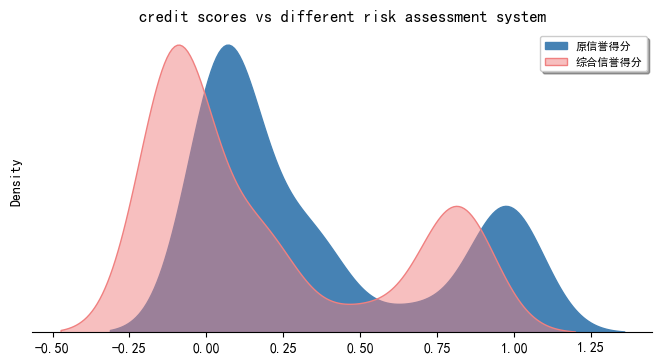

In [ ]:
s_final = [0]*302
alpha = 0.2
for i in range(302):
    e = s3[cate_list[i]]
    s_final = s2 - alpha*e
    
plt.figure(figsize=(8,4),dpi=100)
ax = plt.subplot(1,1,1)

ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(axis='y',length=0)
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)
sns.kdeplot(s2,color='steelblue', shade=True, alpha=1,label='原信誉得分')
sns.kdeplot(s_final,color='lightcoral', shade=True, alpha=0.5,label='综合信誉得分')
plt.title('credit scores vs different risk assessment system')
plt.legend(shadow=True,fontsize=8)
plt.show()

最后使用综合信誉得分来预测其违约率,并进行重新的策略调整

In [ ]:
l3_list = np.array([func(i, popt[0],popt[1],popt[2], popt[3], popt[4]) for i in s_final])


"""============================目标函数============================"""
m_list3 = l3_list[D_index2]  # y2为预测的违约率
lk_model2 = []
for i in D_index2:
    lk_model2.append(lk_model_list2[i])

def aim(Phen, NIND):  # 传入种群染色体矩阵解码后的基因表现型矩阵
    
    r = Phen[:,0]
    a = np.zeros((NIND,139))
    for i in range(1,140):
        a[:,i-1] = Phen[:,i]
    
    lk_list = np.zeros((NIND,139))
    
    for n in range(NIND):
        for i in range(139):
            if lk_model2[i] != 0:
                temp_r = r[n]
                temp_r = np.array([temp_r]).reshape((-1,1))
                lk_list[n][i] = lk_model2[i].predict(temp_r)
            else:
                lk_list[n][i] = 0
    
    temp_sum = np.zeros((NIND,1))
    
    penalty = np.sum(a,axis=1)
    penalty_idx = [i for i,j in enumerate(penalty) if j > 10000]  # 1个亿
    penalty_num = np.zeros((NIND,1))
    penalty_num[penalty_idx] = 100000  # 为超过定额的部分设置惩罚项
    
    for n in range(NIND):
        for i in range(139):
            o1 = a[n][i]*r[n]*(1-m_list3[i]) - a[n][i]*m_list3[i]
            o2 = 1 - lk_list[n][i]
            o = o1 * o2
            temp_sum[n] = temp_sum[n] + o
        temp_sum[n] = temp_sum[n] - penalty_num[n]
    
            
    return -temp_sum

"""============================变量设置============================"""
r_range = [0.04,0.15]  # 第一个决策变量范围
a1_range = [10, 100]  # 第二个决策变量范围
# a2_range = [0,1]  # D类型不贷款
b1 = [1, 1]  # 第一个决策变量边界，1表示包含范围的边界，0表示不包含
# b2 = [1, 0]  # 设置D类决策上限

# 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界
ranges = r_range
counter = 0
for i in range(139):
    ranges = np.vstack([ranges, a1_range])
ranges = ranges.T

# 生成自变量的边界矩阵
borders = b1
counter = 0
for i in range(139):
    borders = np.vstack([borders, b1])
borders = borders.T

varTypes = np.array([0]+[1]*139)  # 决策变量的类型，0表示连续，1表示离散

"""==========================染色体编码设置========================="""
Encoding = 'BG'  # 'BG'表示采用二进制/格雷编码
codes = [1]*140  # 决策变量的编码方式，两个1表示变量均使用格雷编码
precisions = [2]*140  # 决策变量的编码精度，表示解码后能表示的决策变量的精度可达到小数点后6位
scales = [0]*140  # 0表示采用算术刻度，1表示采用对数刻度#调用函数创建译码矩阵
FieldD = ea.crtfld(Encoding, varTypes, ranges, borders, precisions, codes, scales)

"""=========================遗传算法参数设置========================"""
NIND = 50  # 种群个体数目
MAXGEN = 200  # 最大遗传代数
maxormins = np.array([1])  # 表示目标函数是最小化，元素为-1则表示对应的目标函数是最大化
selectStyle = 'sus'  # 采用随机抽样选择
recStyle = 'xovdp'  # 采用两点交叉
mutStyle = 'mutbin'  # 采用二进制染色体的变异算子
Lind = int(np.sum(FieldD[0, :]))  # 计算染色体长度
pc = 0.9  # 交叉概率
pm = 1 / Lind  # 变异概率
obj_trace = np.zeros((MAXGEN, 2))  # 定义目标函数值记录器
var_trace = np.zeros((MAXGEN, Lind))  # 染色体记录器，记录历代最优个体的染色体

"""=========================开始遗传算法进化========================"""
start_time = time.time()  # 开始计时
Chrom = ea.crtpc(Encoding, NIND, FieldD)  # 生成种群染色体矩阵
variable = ea.bs2ri(Chrom, FieldD)  # 对初始种群进行解码
ObjV = aim(variable,NIND)  # 计算初始种群个体的目标函数值
best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号

# 开始进化
for gen in range(MAXGEN):
    FitnV = ea.ranking(maxormins * ObjV)  # 根据目标函数大小分配适应度值
    SelCh = Chrom[ea.selecting(selectStyle, FitnV, NIND - 1), :]  # 选择
    SelCh = ea.recombin(recStyle, SelCh, pc)  # 重组
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm)  # 变异
    # #把父代精英个体与子代的染色体进行合并，得到新一代种群
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    Phen = ea.bs2ri(Chrom, FieldD)  # 对种群进行解码(二进制转十进制)
    ObjV = aim(Phen, NIND)  # 求种群个体的目标函数值
    # 记录
    best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号
    obj_trace[gen, 0] = np.sum(ObjV) / ObjV.shape[0]  # 记录当代种群的目标函数均值
    obj_trace[gen, 1] = ObjV[best_ind]  # 记录当代种群最优个体目标函数值
    var_trace[gen, :] = Chrom[best_ind, :]  # 记录当代种群最优个体的染色体
    # 进化完成
    end_time = time.time()  # 结束计时
# ea.trcplot(obj_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])  # 绘制图像

"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD)  # 解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x' + str(i + 1) + '=', variable[0, i])

print('用时：', end_time - start_time, '秒')


最优解的目标函数值： 25.066693189976167
最优解的决策变量值为：
x1= 0.15
x2= 89.0
x3= 48.0
x4= 81.0
x5= 12.0
x6= 10.0
x7= 96.0
x8= 13.0
x9= 16.0
x10= 60.0
x11= 12.0
x12= 16.0
x13= 72.0
x14= 28.0
x15= 28.0
x16= 89.0
x17= 10.0
x18= 11.0
x19= 43.0
x20= 72.0
x21= 81.0
x22= 68.0
x23= 64.0
x24= 21.0
x25= 29.0
x26= 11.0
x27= 53.0
x28= 91.0
x29= 36.0
x30= 82.0
x31= 97.0
x32= 94.0
x33= 91.0
x34= 62.0
x35= 87.0
x36= 94.0
x37= 16.0
x38= 34.0
x39= 12.0
x40= 19.0
x41= 11.0
x42= 99.0
x43= 43.0
x44= 94.0
x45= 92.0
x46= 10.0
x47= 11.0
x48= 10.0
x49= 70.0
x50= 97.0
x51= 92.0
x52= 16.0
x53= 43.0
x54= 12.0
x55= 10.0
x56= 10.0
x57= 12.0
x58= 51.0
x59= 11.0
x60= 13.0
x61= 28.0
x62= 88.0
x63= 14.0
x64= 16.0
x65= 99.0
x66= 84.0
x67= 21.0
x68= 96.0
x69= 16.0
x70= 89.0
x71= 16.0
x72= 34.0
x73= 100.0
x74= 21.0
x75= 61.0
x76= 11.0
x77= 99.0
x78= 80.0
x79= 99.0
x80= 57.0
x81= 90.0
x82= 94.0
x83= 12.0
x84= 14.0
x85= 87.0
x86= 54.0
x87= 11.0
x88= 98.0
x89= 22.0
x90= 24.0
x91= 13.0
x92= 21.0
x93= 21.0
x94= 89.0
x95= 16.0
x96= 13.0
x97= 9